Variables of filenames

In [59]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/inz/jupyter/'
fileName = directory + 'PlainTree1M_ml_URQMD_12gev.root'


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
from matplotlib.backends.backend_pdf import PdfPages
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from bayes_opt import BayesianOptimization
# from bayes_opt import SequentialDomainReductionTransformer

import gc, os
from enum import Enum

In [61]:
#CUTS USED FOR DATA CLEANING
#momentums cuts
pzLowerCut = 0
pUpperCut = 12
ptUpperCut = 2
m2LowerCut = -1
m2UpperCut = 2
#time
tUpperCut = 40
#pid codes of particles
class Pid(Enum):
    ELECTRON = 11
    # POSITRON = -11
    # ELECTRON = 11
    PROTON = 2212 
    # NEG_MUON = -13
    # POS_MUON = 13
    MUON = 13
    # NEG_PION = -211
    # POS_PION = 211 
    PION = 211
    # NEG_KAON = -321
    # POS_KAON = 321 
    KAON = 321
    BCKGR = 999
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 
    
def clean_df(df, info = 0):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #pz
    size_pz =  len(df['pz'])
    is_good_pz = (df['pz'] > pzLowerCut)
    percentage_pz = ( size_pz - len(df[is_good_pz]) ) / size_pz
    #p
    size_p =  len(df['p'])
    is_good_p = (df['p'] < pUpperCut)
    percentage_p = ( size_p - len(df[is_good_p]) ) / size_p
    #p
    size_pt =  len(df['pT'])
    is_good_pt = (df['pT'] < ptUpperCut)
    percentage_pt = ( size_pt - len(df[is_good_pt]) ) / size_pt
    # #t
    # size_t =  len(df['t'])
    # is_good_t = (df['t'] < tUpperCut)
    # percentage_t = ( size_t - len(df[is_good_t]) ) / size_t
    #mass2
    size_m2 =  len(df['mass2'])
    is_good_m2 = (df['mass2'] > m2LowerCut) & (df['mass2'] < m2UpperCut)
    percentage_m2 = ( size_m2 - len(df[is_good_m2]) ) / size_m2
    is_good_df = (is_good_pz) & (is_good_p) & (is_good_pt) & (is_good_m2) #& (is_good_t)
    if (info == 1):
        print('with the pz selection criteria we lose we loose ' + str(round(percentage_pz*100, 4)) + '% of entries')
        print('with the p selection criteria we lose we loose ' + str(round(percentage_p*100, 4)) + '% of entries')
        print('with the pT selection criteria we lose we loose ' + str(round(percentage_pt*100, 4)) + '% of entries')
        print('with the t selection criteria we lose we loose ' + str(round(percentage_t*100, 4)) + '% of entries')

    return df[is_good_df]
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )
def sigma(df:pd.DataFrame, pid, nsigma=1, info=False):
    mean = df[df['pid']==pid]['mass2'].mean()
    std = df[df['pid']==pid]['mass2'].std()
    out_sigma = (df['pid']==pid) & ((df['mass2'] < (mean-nsigma*std)) | (df['mass2'] > (mean+nsigma*std)))
    df1 = df[~ out_sigma]
    if info:
        df_len = len(df)
        df1_len = len(df1)
        print('we get rid of ' + str ( round( ( df_len - df1_len) / df_len *100, 2)) + ' % of pid = ' 
              + str(pid) + ' particle entries')
    return df1

def xgb_preds(df, probaProton, probaKaon, probaPion):
    #getting max field
    df['xgb_preds']=df[[0, 1, 2]].idxmax(axis = 1)
    #setting to bckgr if smaller than probability threshold
    proton = (df['xgb_preds'] == 0) & (df[0] < probaProton )
    pion   = (df['xgb_preds'] == 1) & (df[1] < probaKaon )
    kaon   = (df['xgb_preds'] == 2) & (df[2] < probaPion )
    df.loc[( proton | pion | kaon ), 'xgb_preds'] = 3
    return df

from collections import defaultdict
def remap_names(dataframe):
    return dataframe.pid.abs().map(defaultdict(lambda: 3, {Pid.PROTON.value : 0, Pid.KAON.value : 1,  Pid.PION.value : 2, Pid.MUON.value : 2}),na_action='ignore')#, Pid.ELECTRON.value : 2, 
 

In [62]:
import matplotlib as mpl
def sim_tof(df, pid):

    qp = df[df['pid']==pid]['q']*df[df['pid']==pid]['p']
    var_xaxis = qp
    mass2 = df[df['pid']==pid]['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [63]:
%%capture
#Shahid's library for importing roottrees
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

In [64]:
# We import three root files into our jupyter notebook
particles = tree_importer.tree_importer(fileName,'plain_tree',7)
particles.columns = particles.columns.str.replace('Complex_', '')
gc.collect()
particles.iloc[0:10,:]

,eta,l,mass,mass2,p,pT,phi,px,py,pz,rapidity,t,pid,q
0,2.795109,796.765564,0.139570,0.044752,3.360802,0.409217,-1.931746,-0.144520,-0.382848,3.335796,2.740521,26.631847,-211.0,-1.0
1,2.862100,797.093079,0.493677,0.248146,2.920601,0.332732,-1.740885,-0.056321,-0.327931,2.901586,2.287393,26.975466,321.0,1.0
2,2.025051,785.335205,0.938272,0.904669,2.650691,0.687733,-2.986821,-0.679512,-0.106017,2.559919,1.529873,27.855837,2212.0,1.0
3,1.962085,745.262451,0.938272,0.842410,3.123042,0.860970,-0.086505,0.857751,-0.074385,3.002019,1.592940,25.919329,2212.0,1.0
4,2.162448,734.718689,0.139570,-0.004009,2.821904,0.640801,0.066599,0.639381,0.042645,2.748184,2.139893,24.501303,-211.0,-1.0
5,3.121445,792.576599,0.938272,1.108287,6.939540,0.610784,1.233429,0.202172,0.576353,6.912608,2.520050,26.742485,2212.0,1.0
6,2.217318,759.005249,0.938272,0.834824,2.472587,0.532222,2.700255,-0.481225,0.227338,2.414628,1.545454,27.027834,2212.0,1.0
7,2.333610,749.677795,0.139570,0.015155,3.696914,0.710121,2.618707,-0.615236,0.354622,3.628071,2.315019,25.072449,211.0,1.0
8,2.156020,733.076660,0.139570,0.015053,5.610508,1.282038,0.950416,0.745306,1.043139,5.462068,2.150286,24.501919,-211.0,1.0
9,2.211525,769.359009,0.139570,0.018099,1.712385,0.370680,1.318592,0.092499,0.358953,1.671783,2.146911,25.997503,-211.0,1.0


Before 1 sigma selection

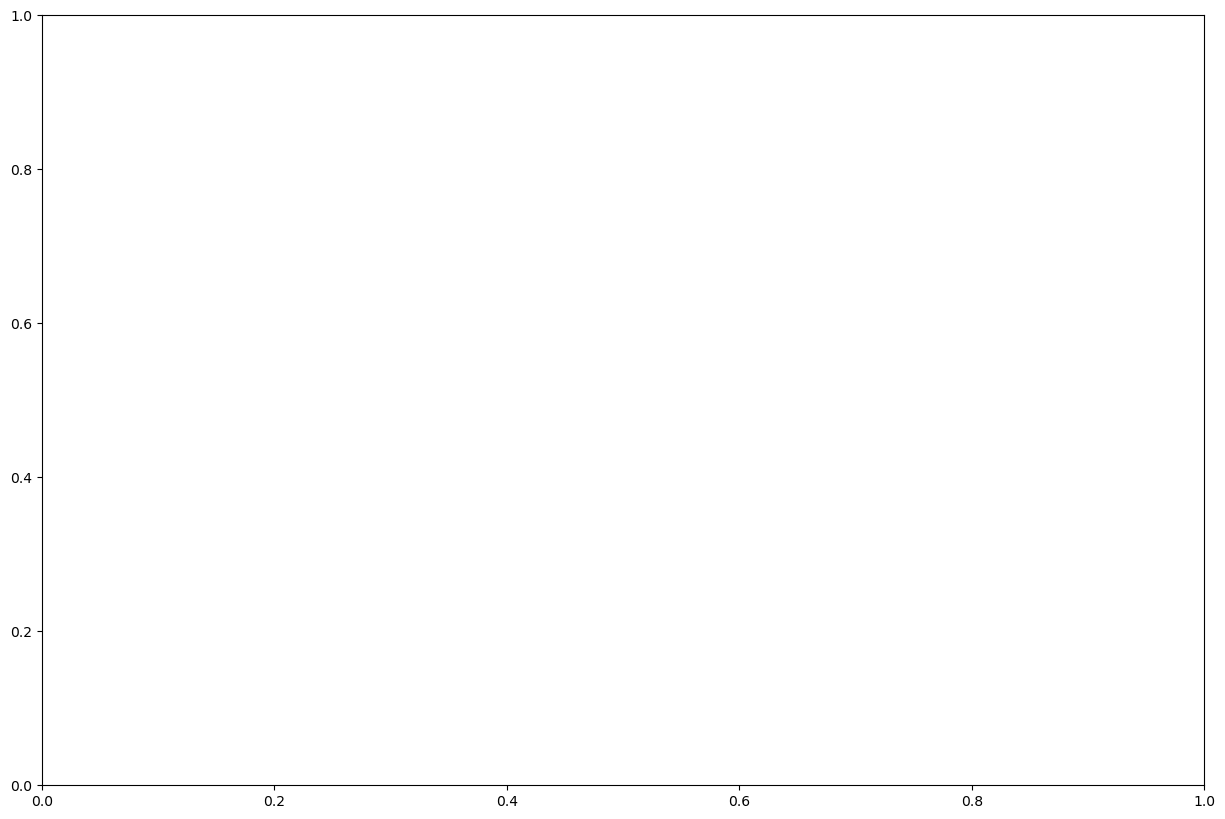

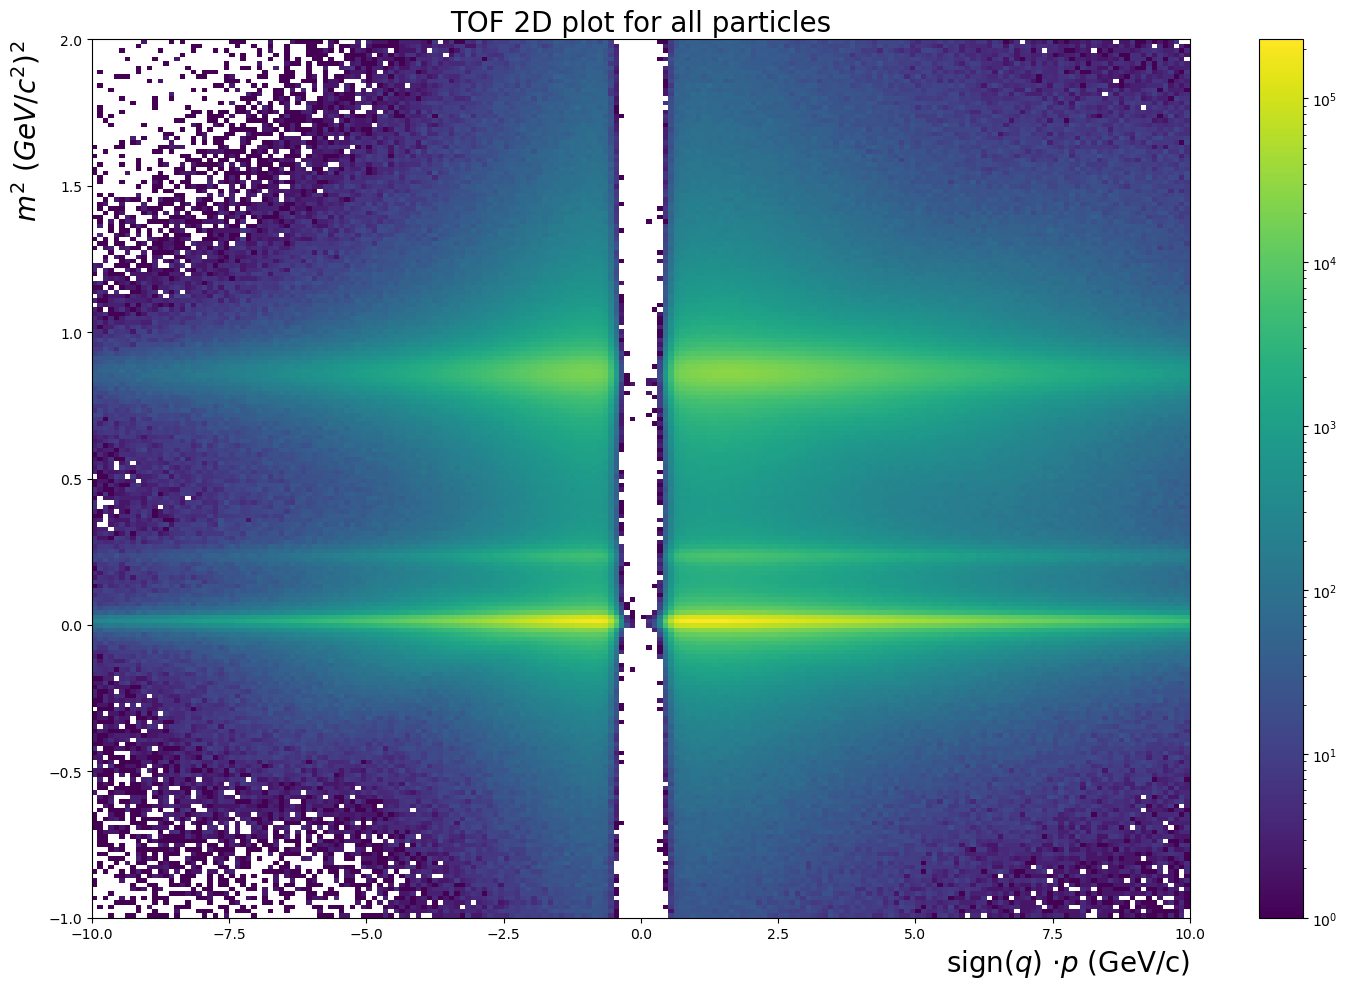

In [65]:
def all_tof(df):

    qp = df['q']*df['p']
    var_xaxis = qp
    mass2 = df['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all particles'
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig
all_tof(particles)

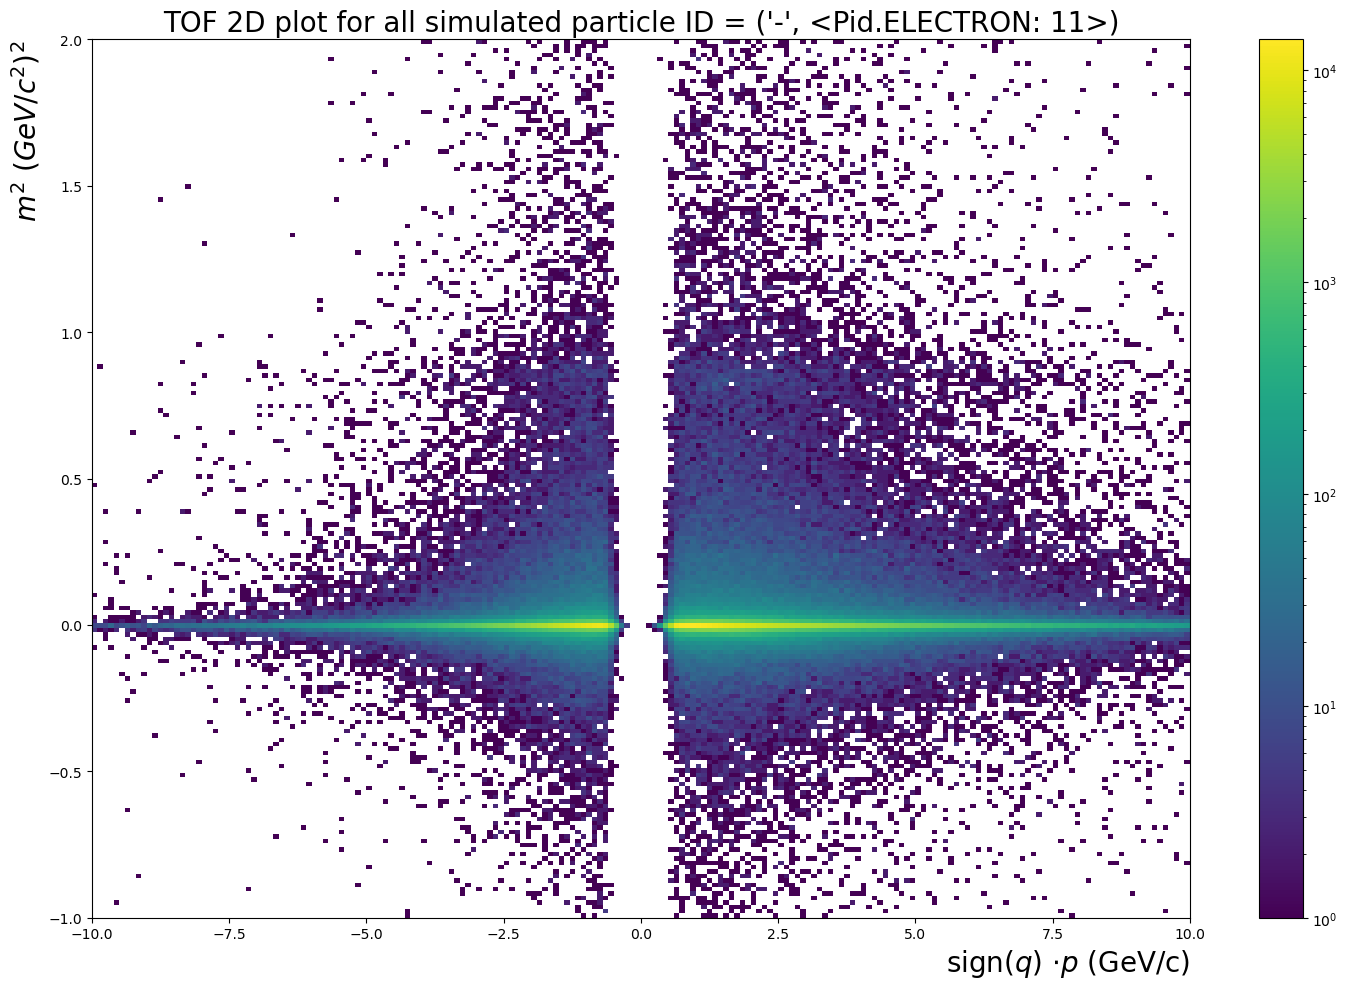

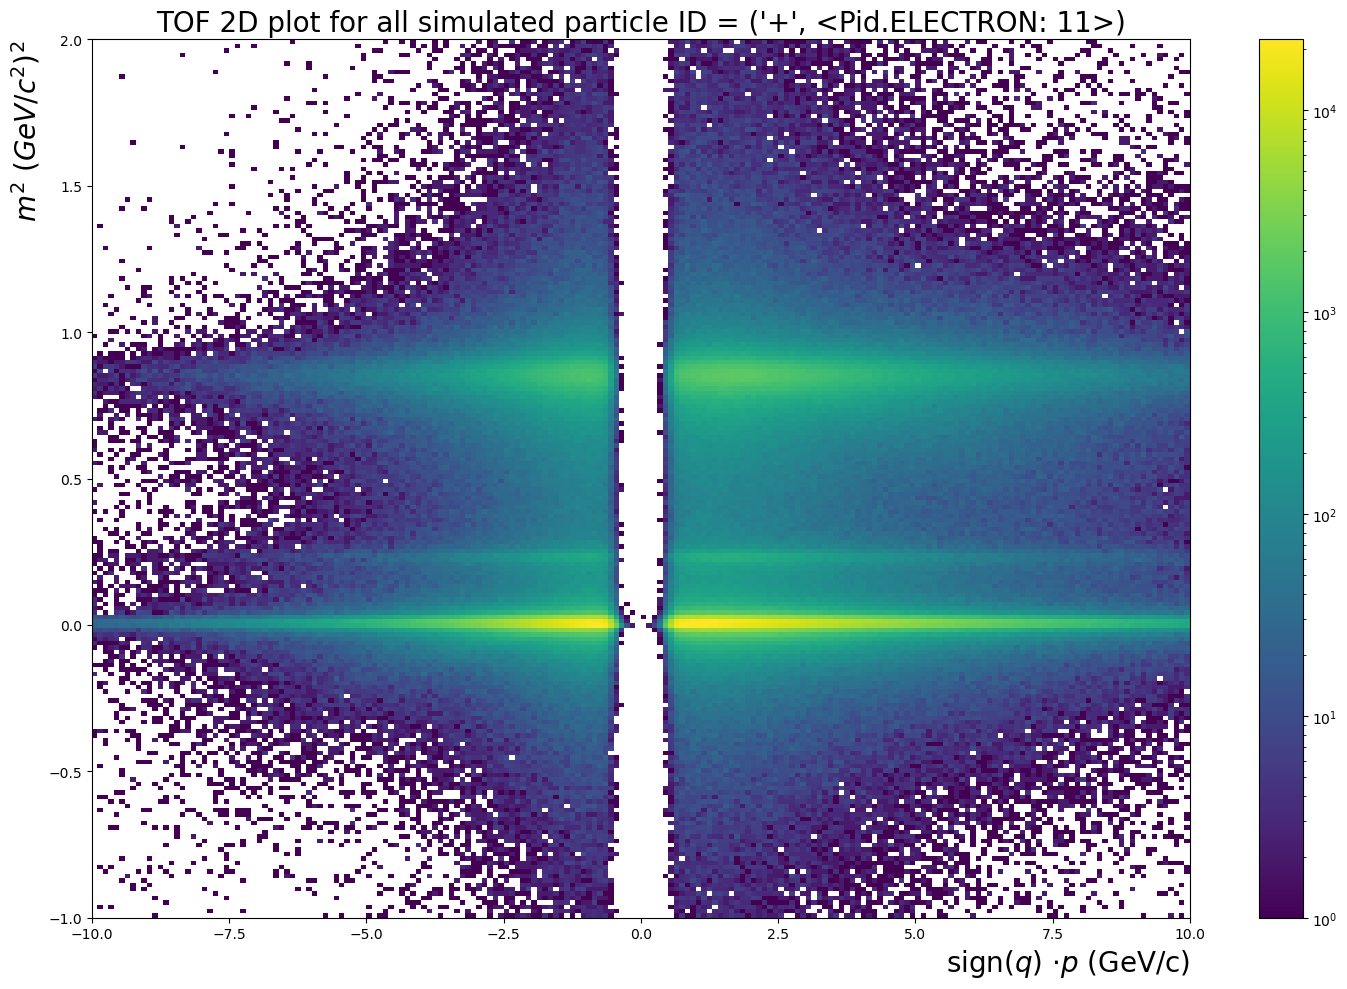

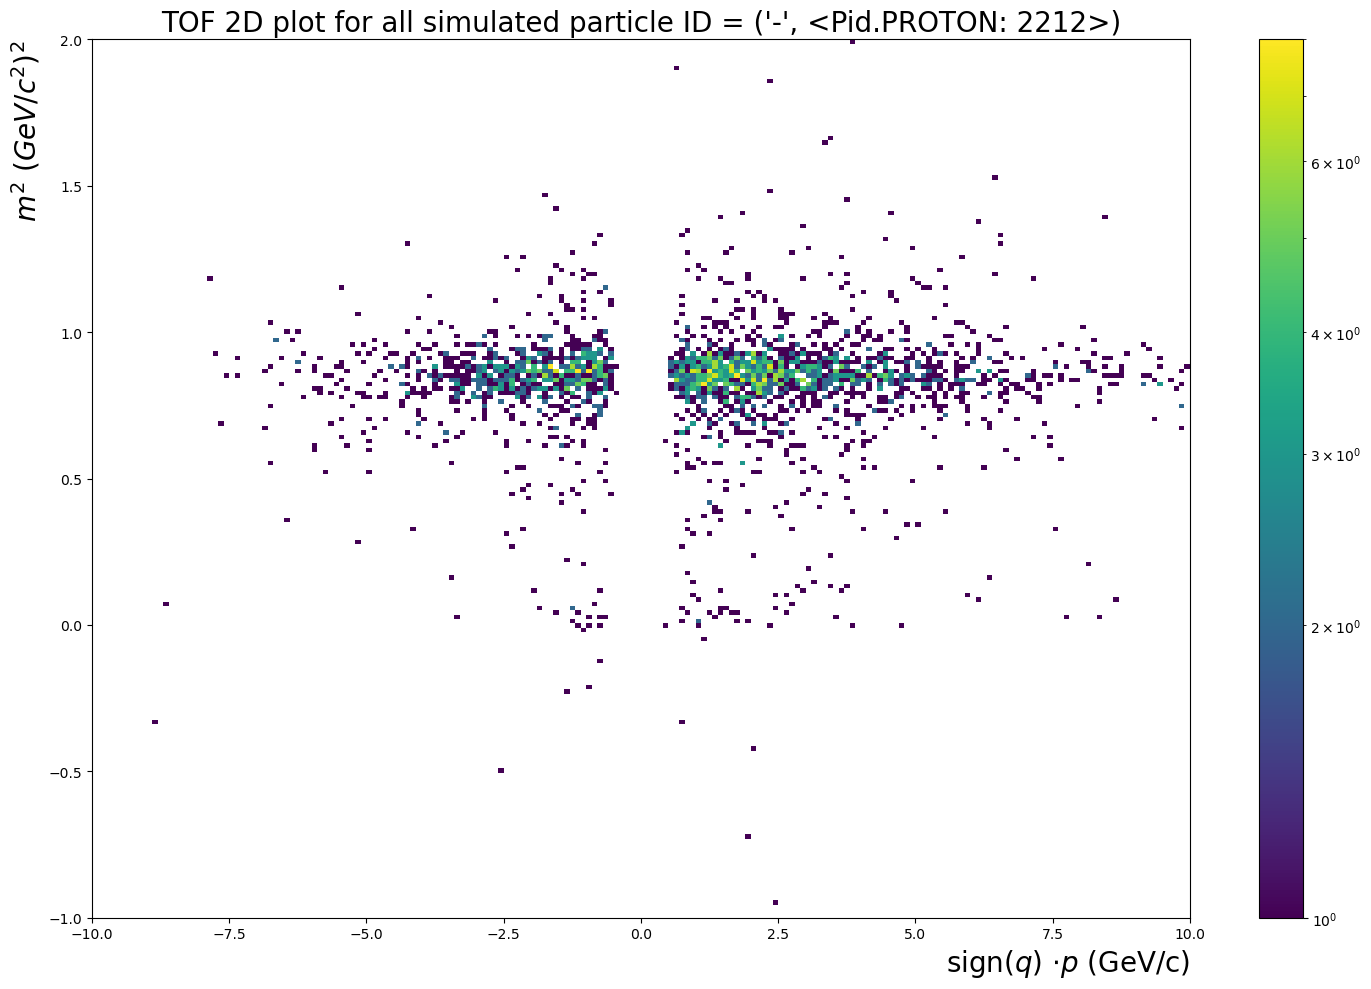

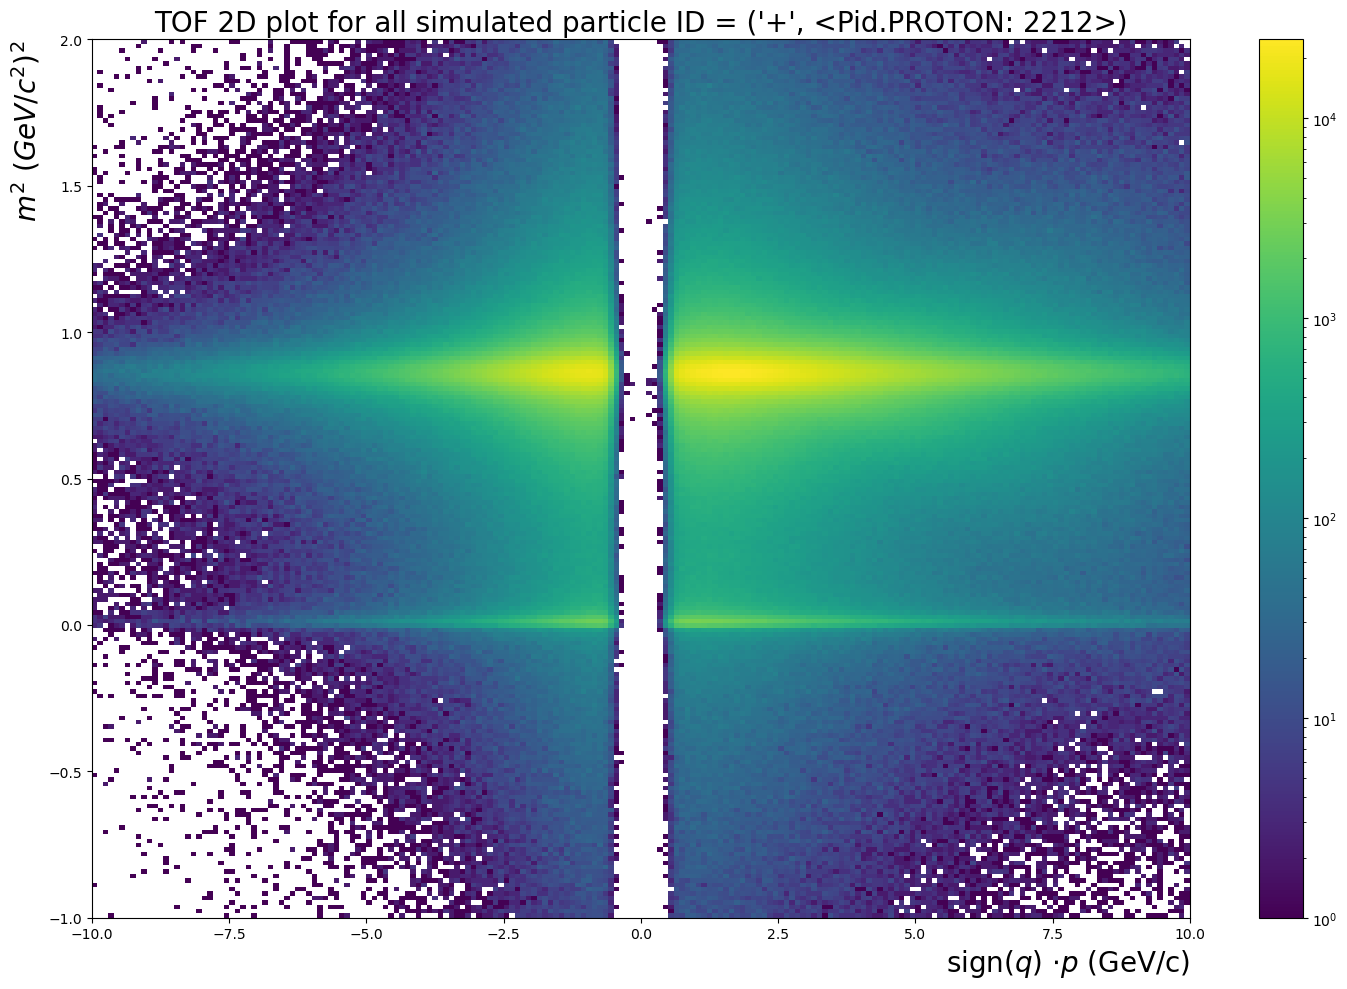

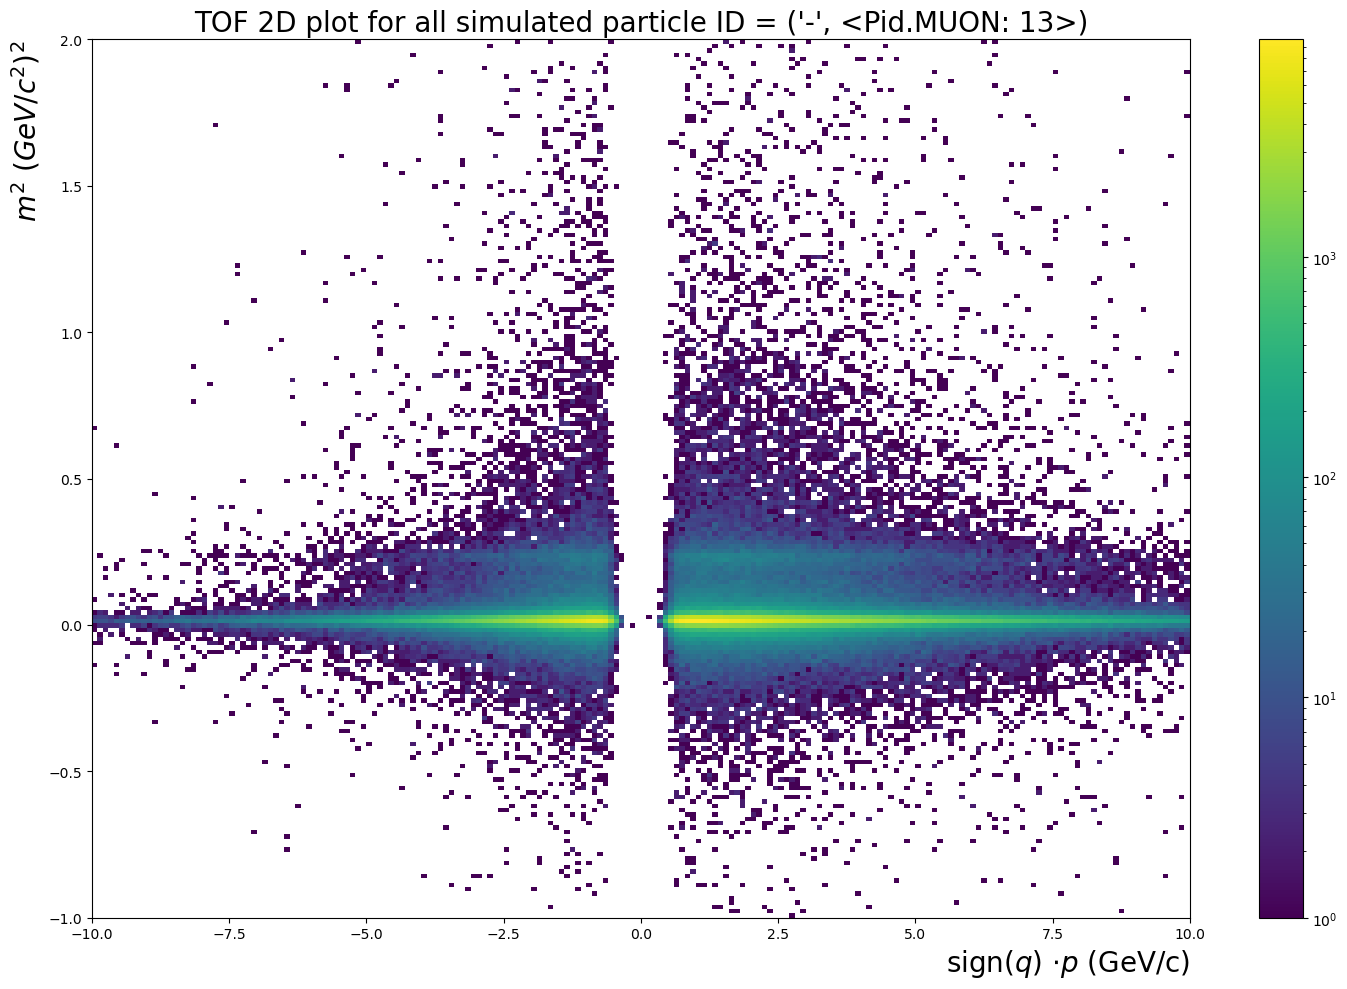

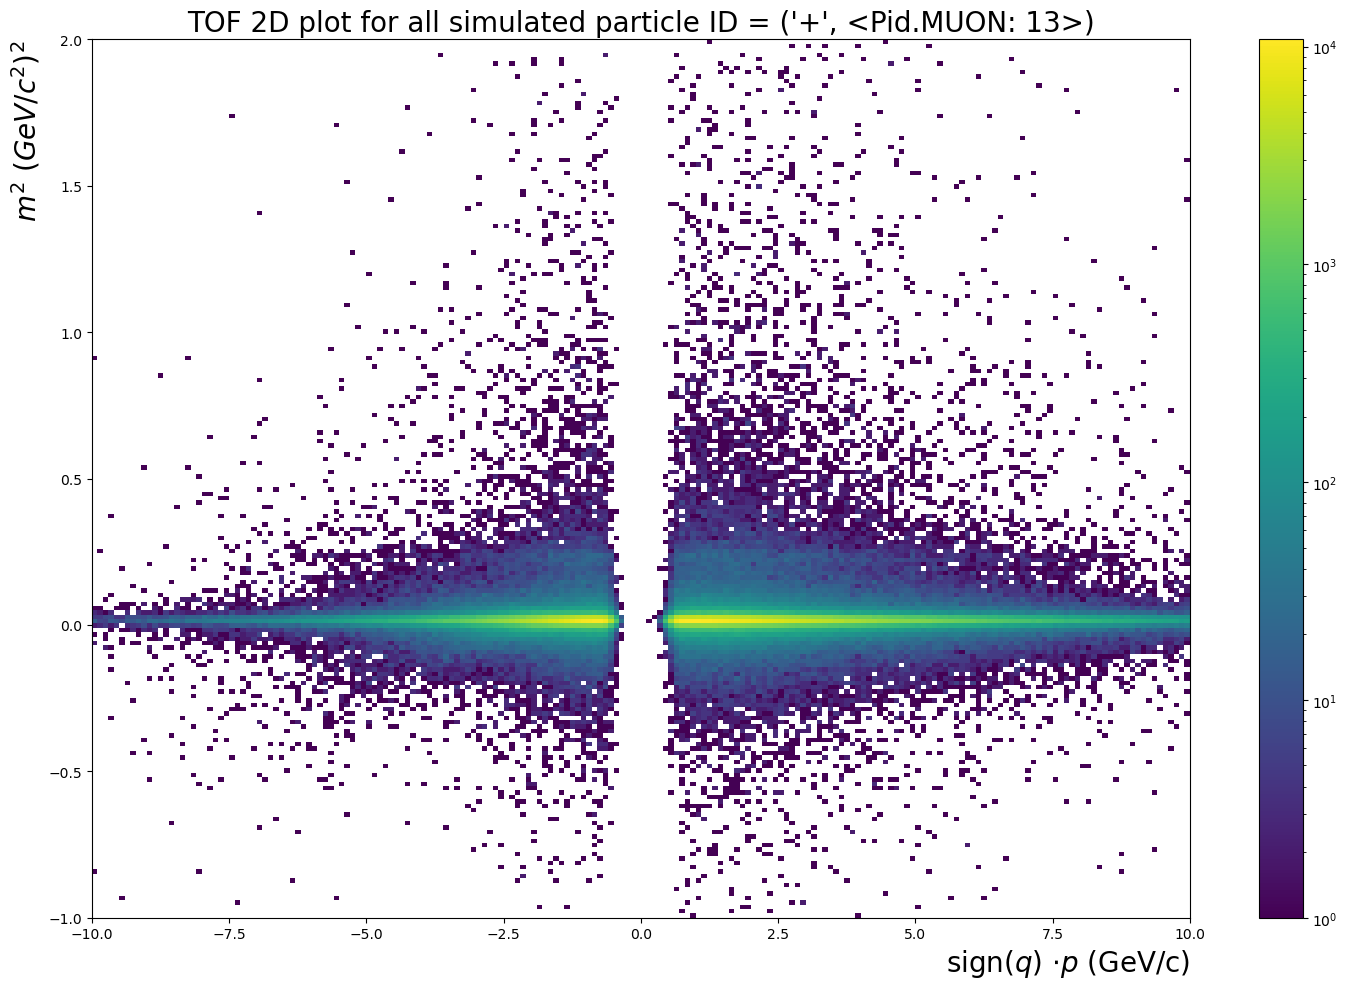

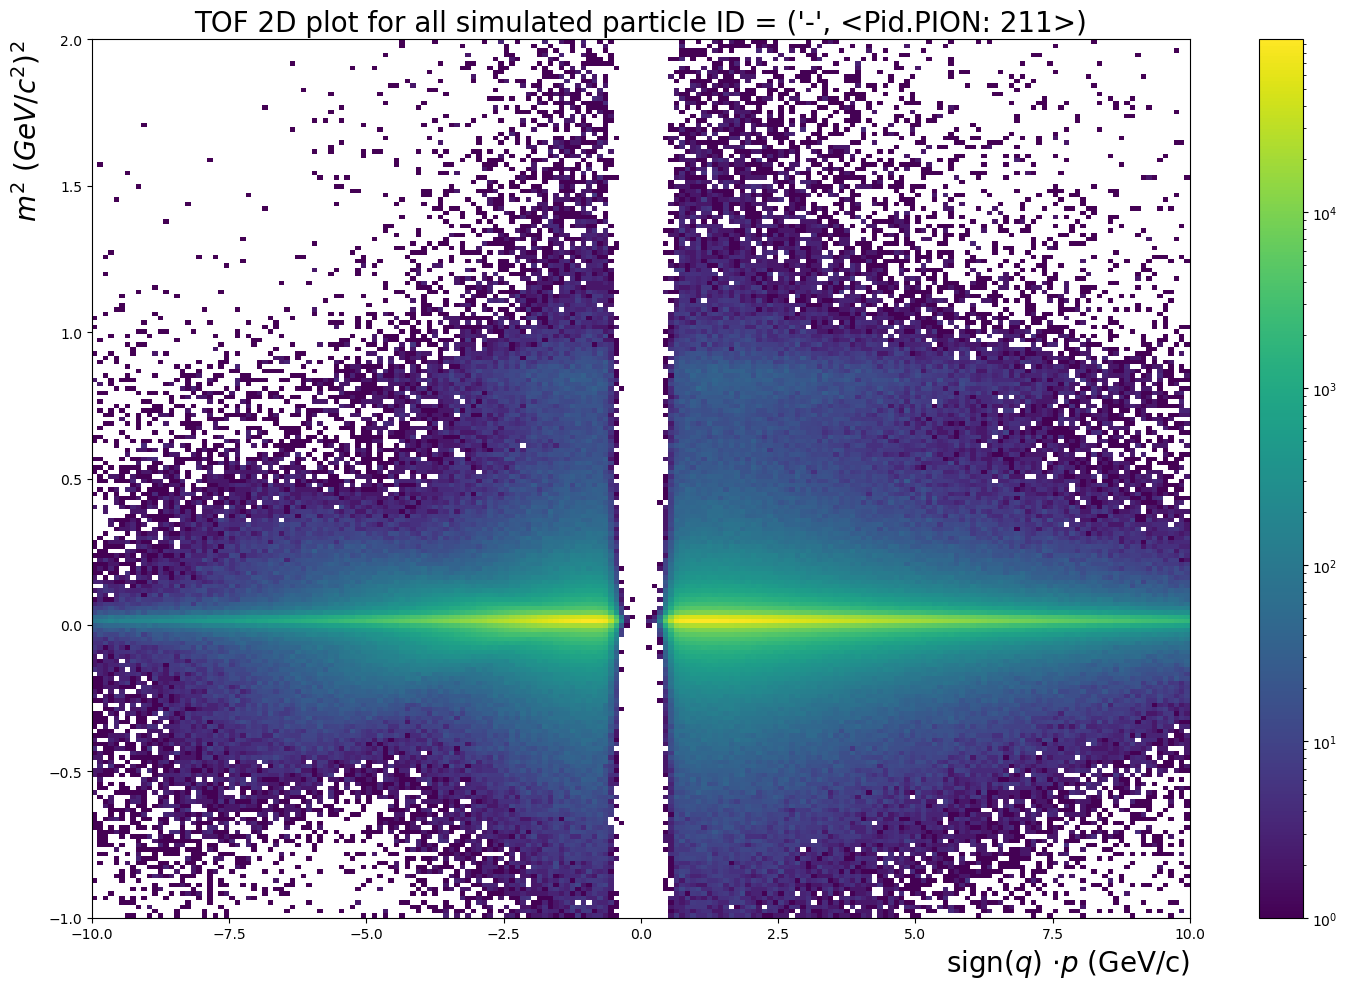

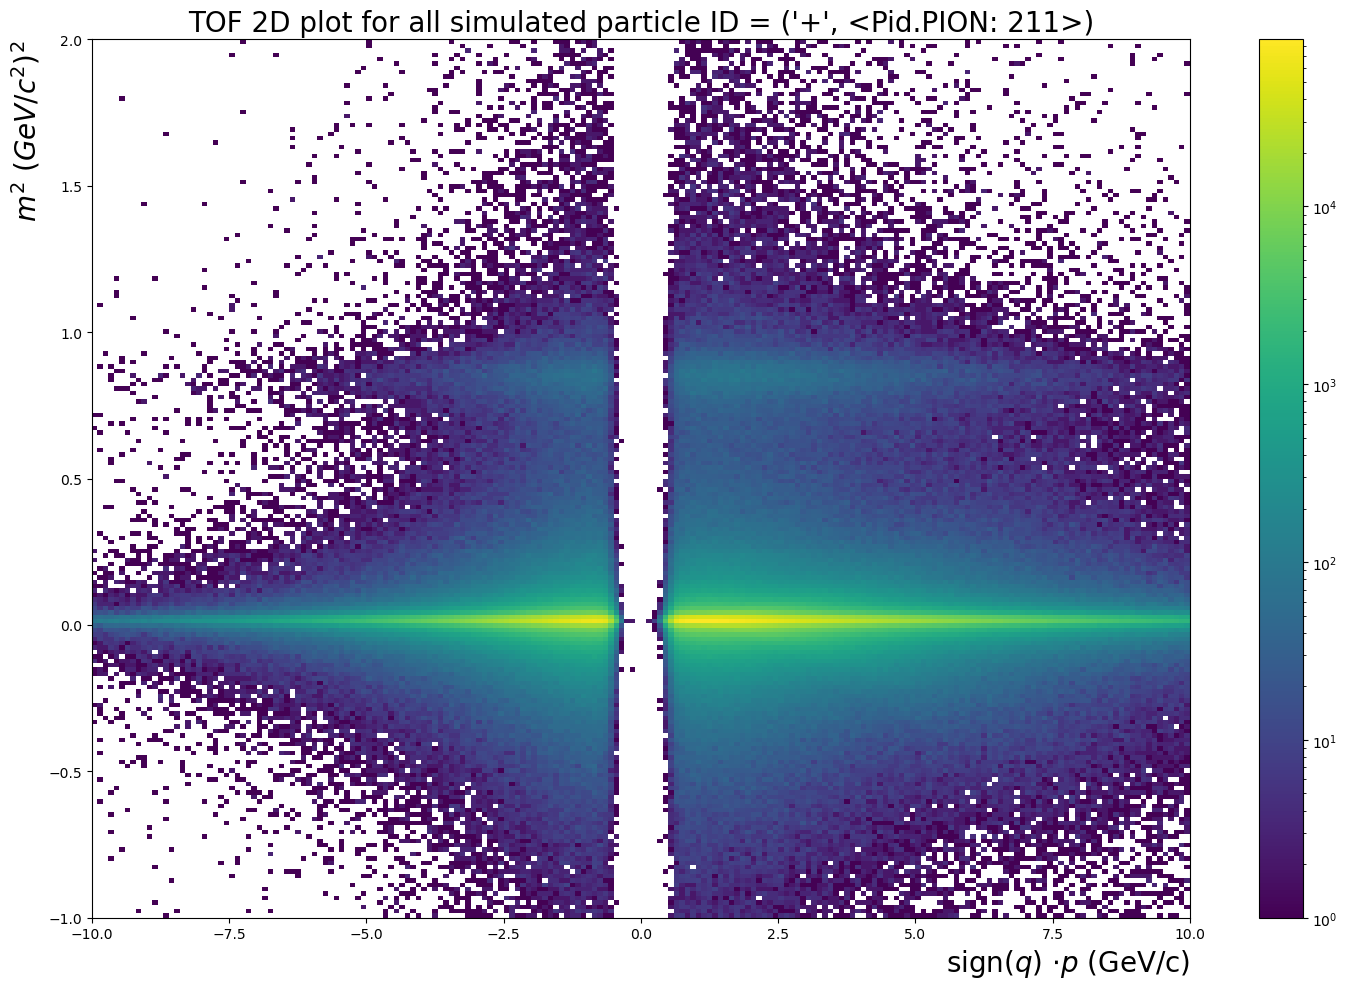

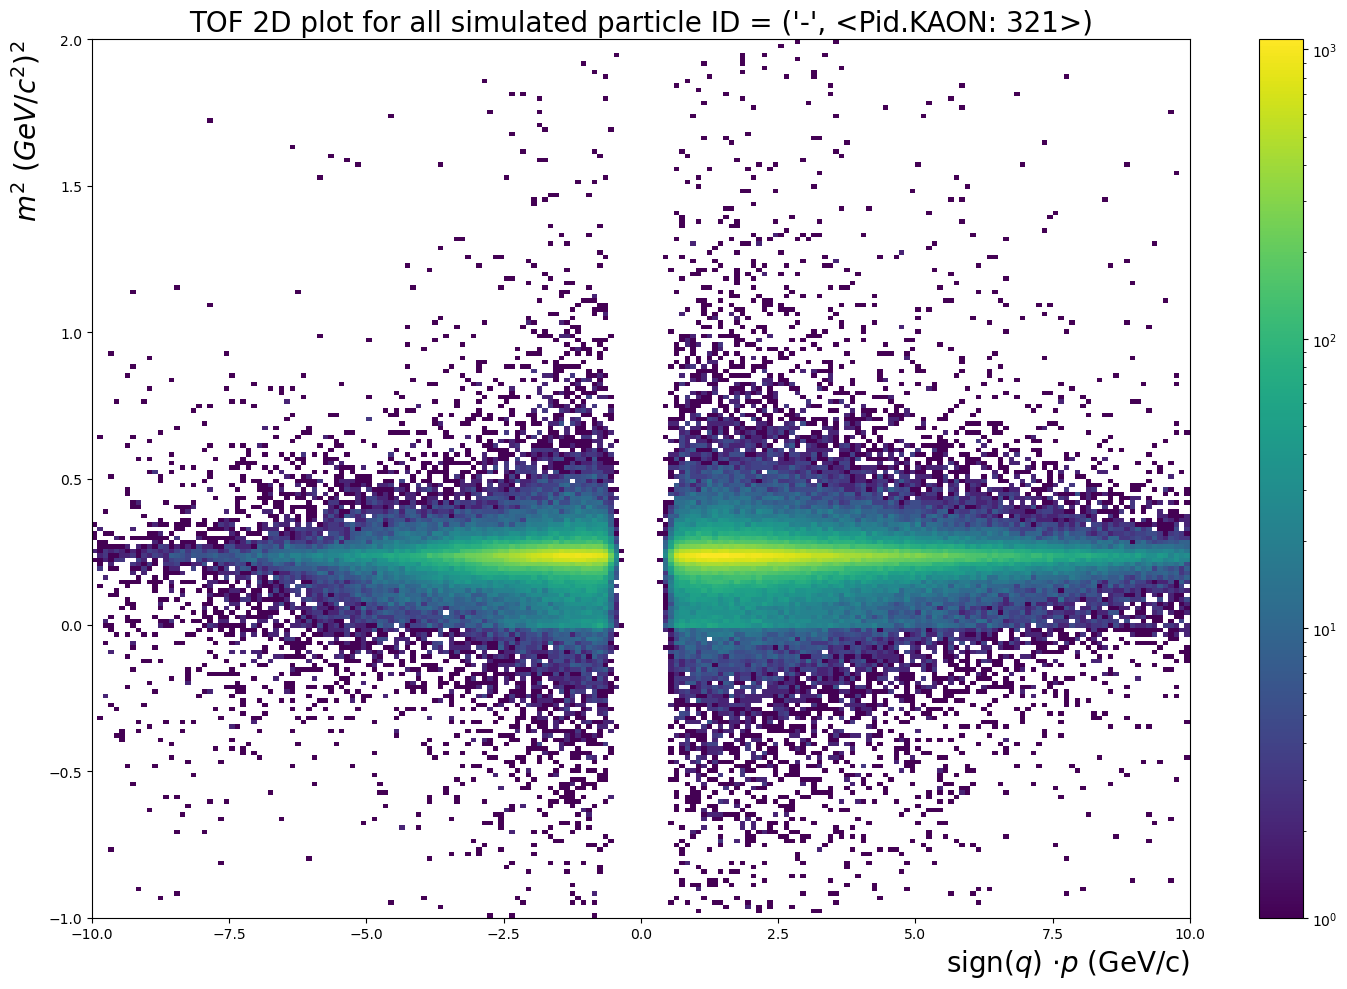

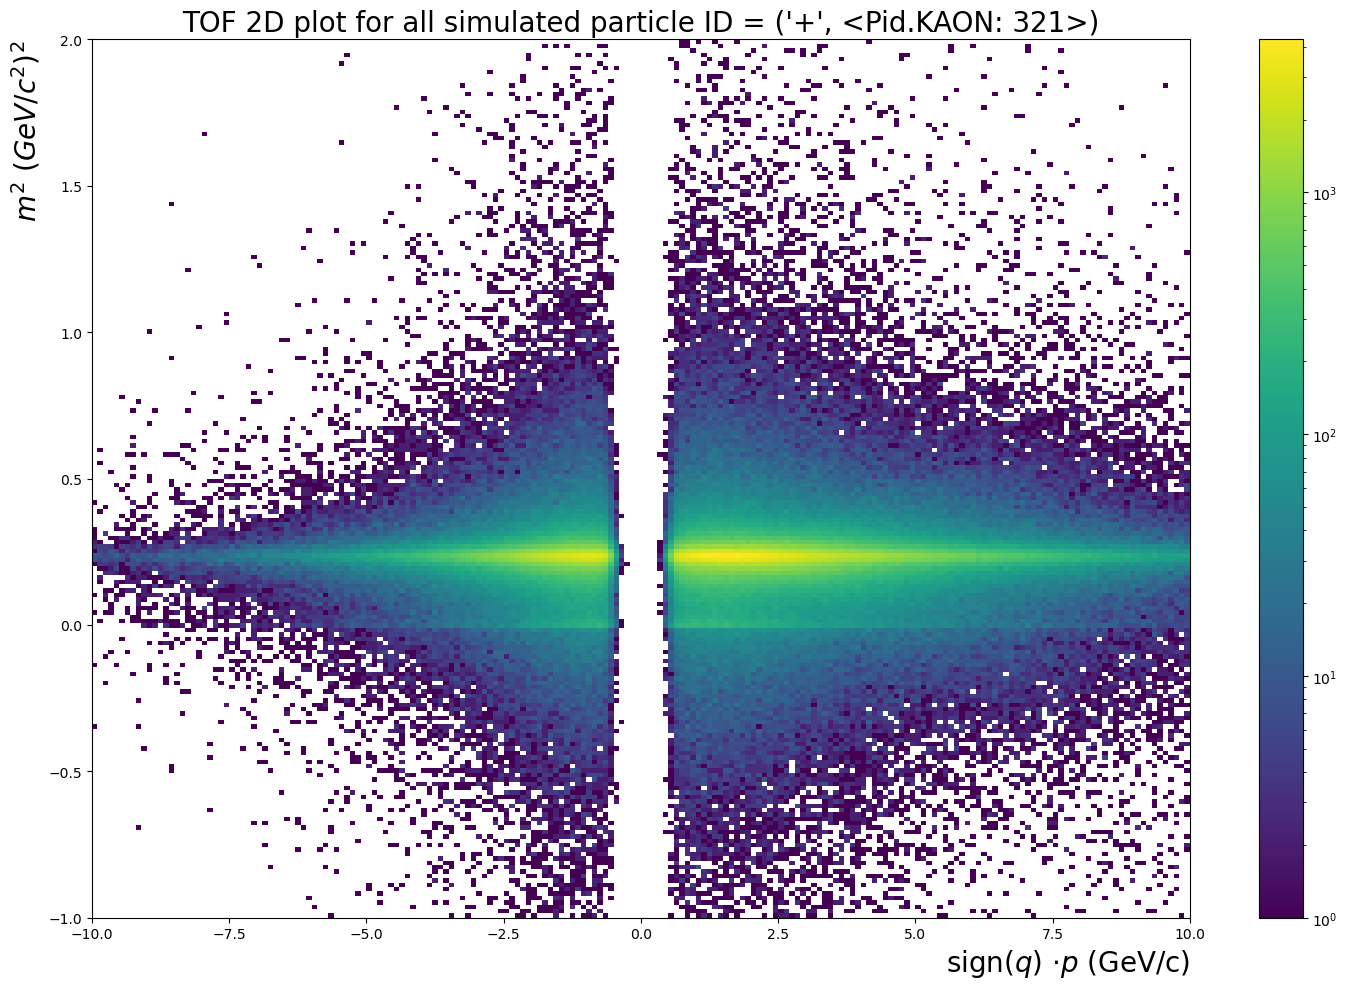

In [67]:
def classes_tof(df, pid, name, antip = 0):
    if antip == 0:
        df['pid'] = df['pid'].abs()
    part = df[df['pid']==pid]
    qp = part['q']*part['p']
    var_xaxis = qp
    mass2 = part['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(name)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')
for pid in Pid:
    if pid != Pid.BCKGR:
        classes_tof(particles, -pid.value, ('-', pid), 1)
        classes_tof(particles, pid.value,  ('+', pid), 1)
        # classes_tof(particles, pid.value, pid)
        
# classes_tof(particles, -11,  'pid', 1)  

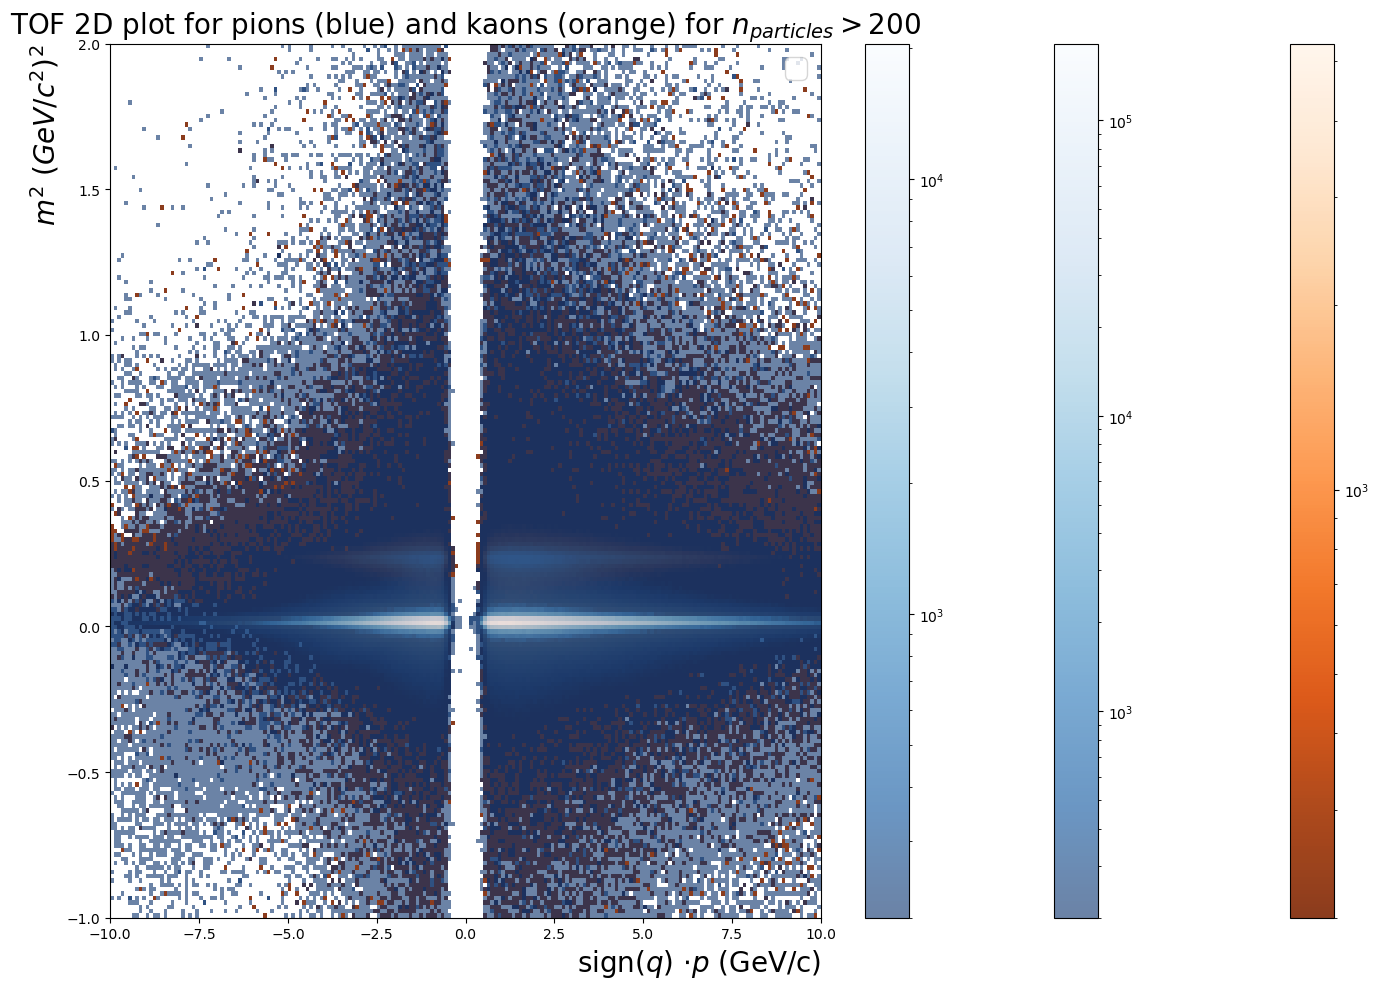

In [9]:
fig, axs = plt.subplots(figsize=(15, 10))
ranges = [[-10, 10],[-1, 2]]
xName = r'sign($q$) $\cdot p$ (GeV/c)'
yName = r'$m^2$ $(GeV/c^2)^2$'

def subplot(pid, name, color, alpha):
    qp = particles[particles['pid']==pid]['q']*particles[particles['pid']==pid]['p']
    mass2 = particles[particles['pid']==pid]['mass2']
    counts, xedges, yedges, im = axs.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=200), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = alpha)
    plt.colorbar(im, ax=axs)
    # plt.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=100), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = 0.9)


subplot(Pid.KAON.value, 'kaons', 'Oranges_r', .9)
subplot(Pid.PION.value, 'pions', 'Blues_r', .6)
subplot(Pid.MUON.value, 'pions', 'Blues_r', .6) #as we use it also




plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title=r'TOF 2D plot for pions (blue) and kaons (orange) for $n_{particles} > 200$'
plt.title(title, fontsize=20)
axs.legend('Classes of particles', fontsize = 20, loc='upper right')
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.show()

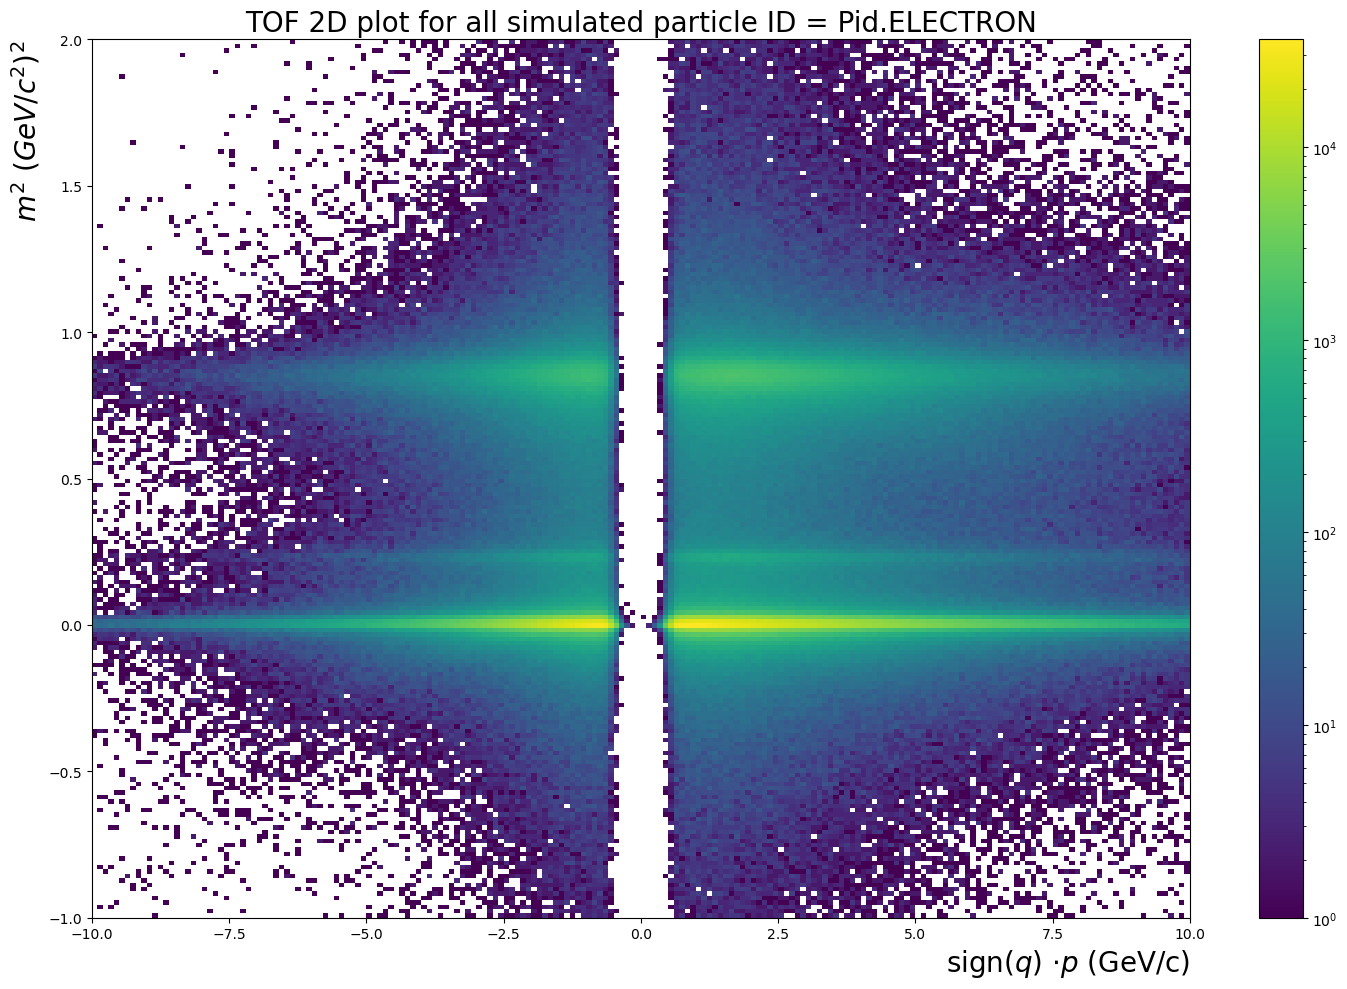

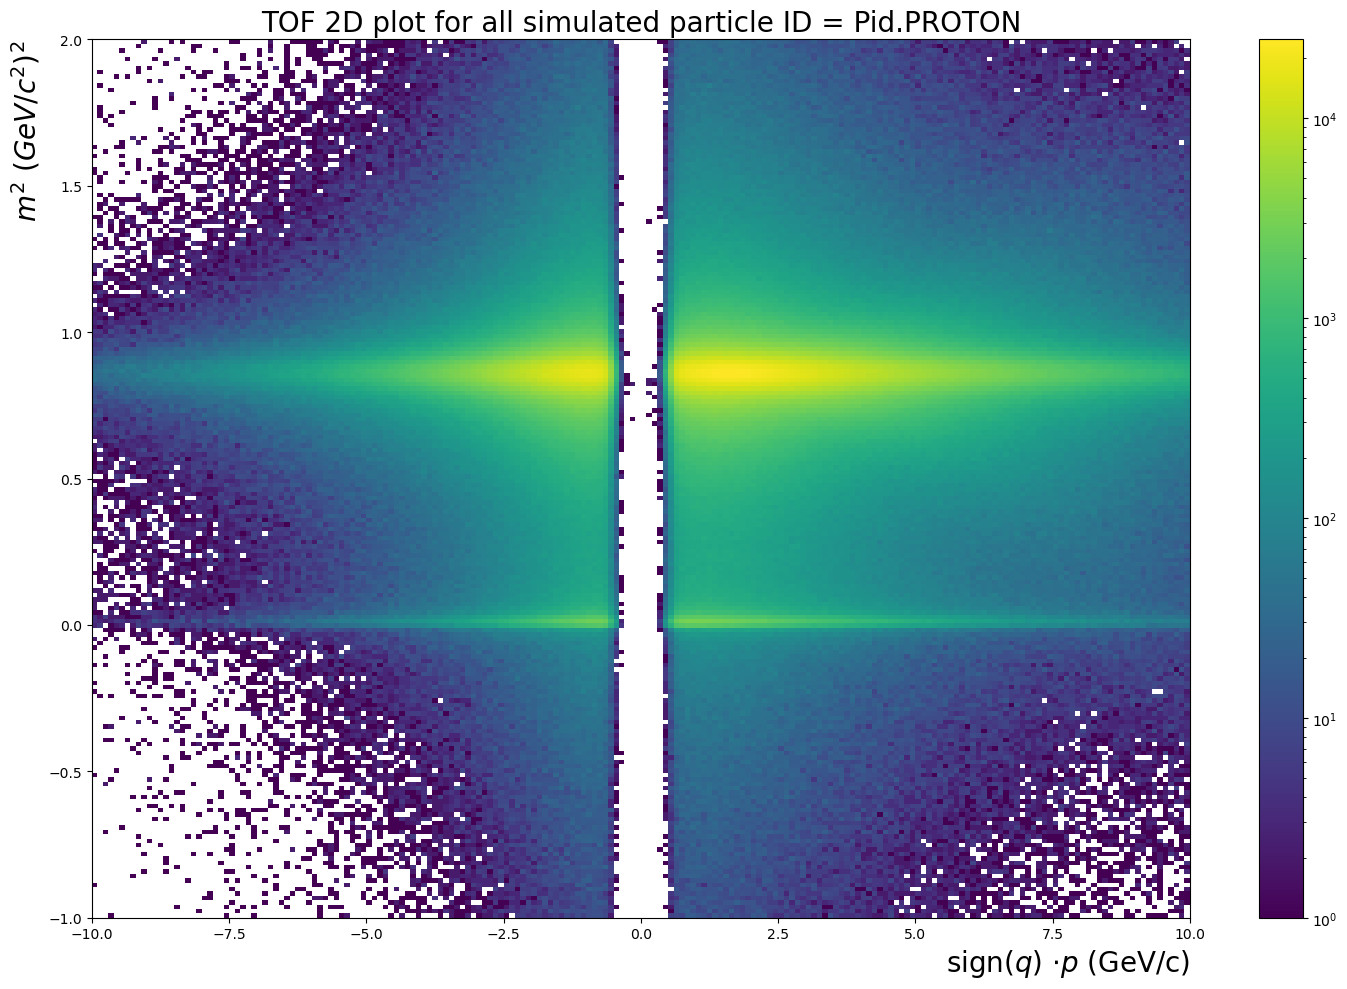

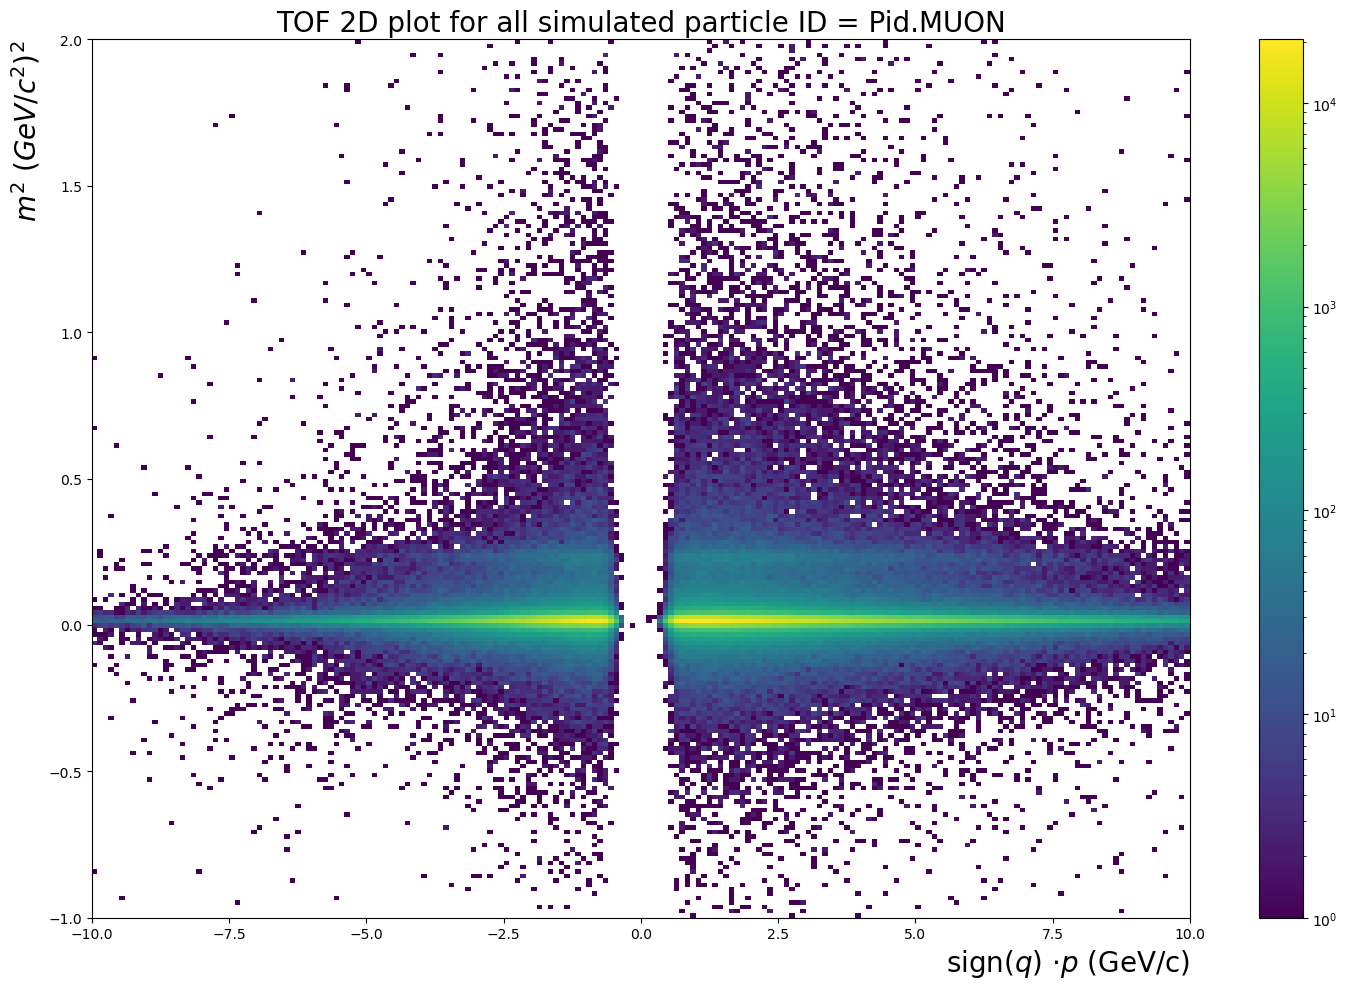

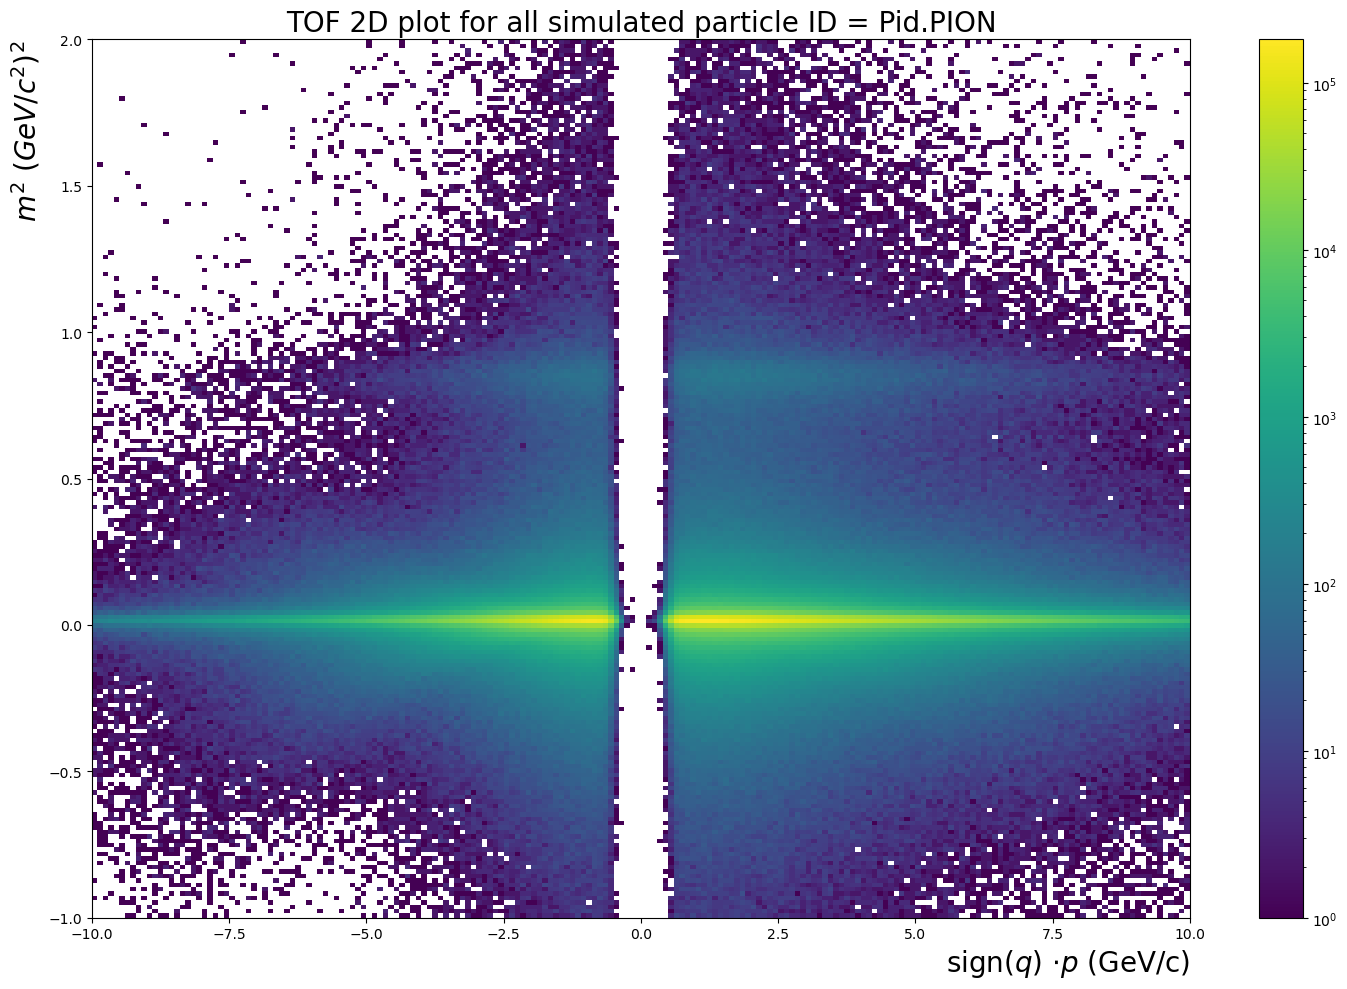

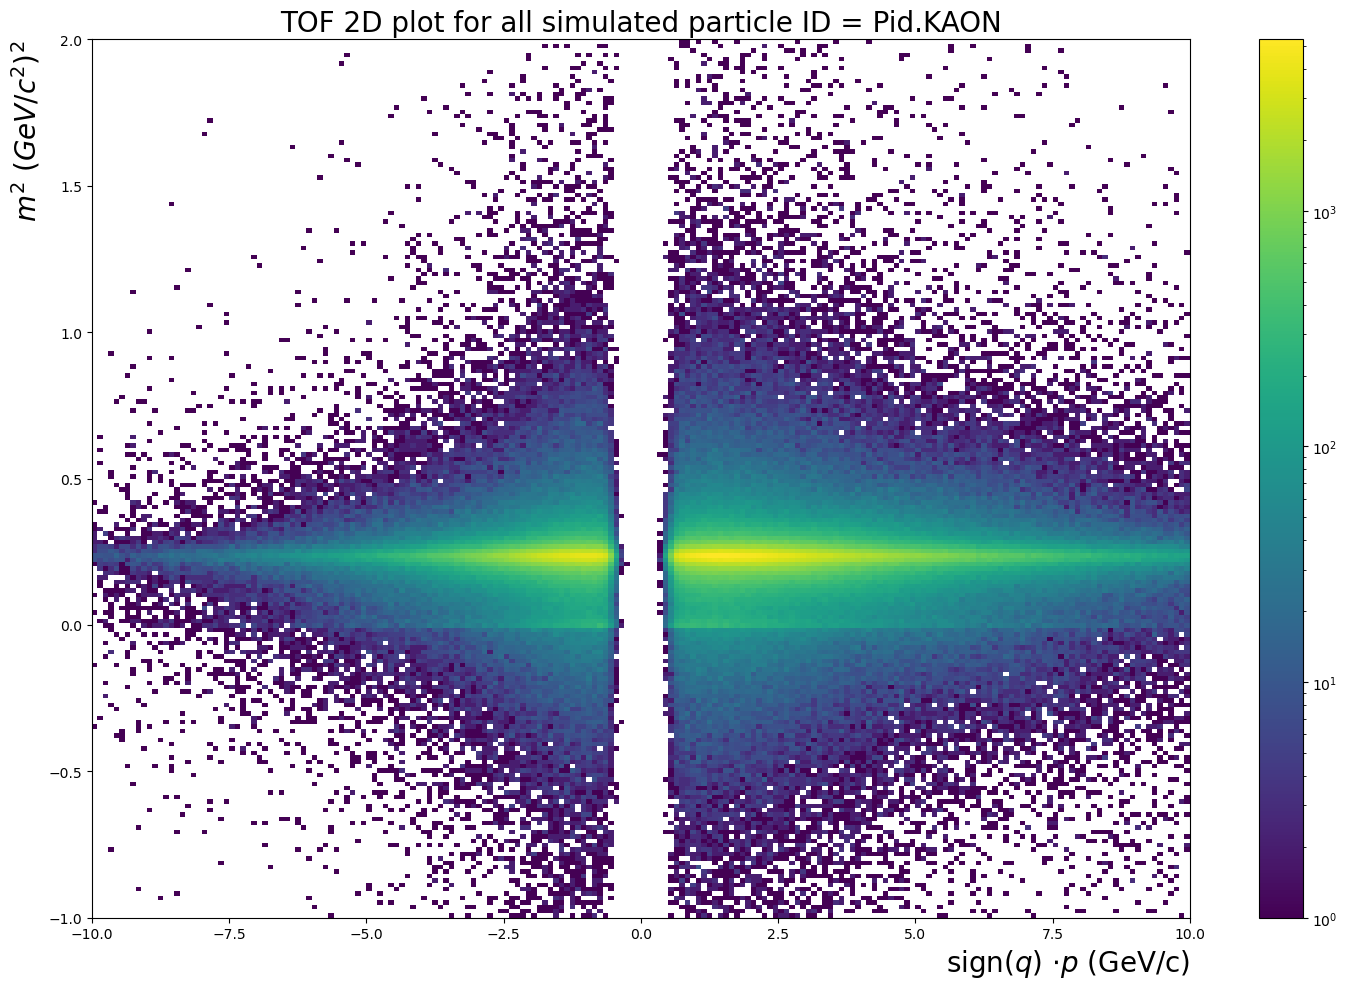

In [53]:
for pid in Pid:
    if pid != Pid.BCKGR:
        classes_tof(particles, pid.value, pid)

After 1 sigma selection

In [54]:

particles['pid'] = remap_names(particles)
#dropping bckgr value for training
particles = particles[particles['pid'] != 3]
gc.collect()
print('number of particles before downsampling : ' + str(len(particles)))

#downsampling the data

particles = downsample(particles, 'pid')
print('number of particles per class after downsampling : ' + str(len(particles)/3))
particles.iloc[0:10,:]
#cleaning and 1sigma region selection
# particles = clean_df(particles)
# for particle in particles['pid'].unique(): 
#     particles = sigma(particles, particle, 1, True)

number of particles before downsampling : 37702324
number of particles per class after downsampling : 1385378.0


,eta,l,mass,mass2,p,pT,phi,px,py,pz,rapidity,t,pid,q
0,1.754987,769.245789,0.938272,0.883985,1.999332,0.671336,2.320608,-0.457516,0.491295,1.883252,1.266002,26.532143,0,1.0
1,1.879542,794.714844,0.938272,0.191270,2.951312,0.880573,2.469739,-0.689198,0.548102,2.816884,1.525150,26.927105,0,1.0
2,2.119893,758.120972,0.938272,0.830330,5.876987,1.390956,3.114547,-1.390447,0.037616,5.710011,1.938786,26.744905,0,-1.0
3,1.708475,783.888611,0.938272,0.910964,1.339865,0.469990,-0.171353,0.463107,-0.080140,1.254730,1.013193,26.229975,0,-1.0
4,1.442198,749.411072,0.938272,0.938867,1.093057,0.489458,2.268422,-0.314428,0.375106,0.977345,0.826259,26.879169,0,1.0
5,1.735322,748.629333,0.938272,0.759389,0.451847,0.154554,-2.990777,-0.152800,-0.023221,0.424593,0.432864,25.217674,0,1.0
6,2.458107,806.226990,0.938272,0.750244,2.078447,0.353228,-2.167439,-0.198468,-0.292200,2.048212,1.462694,27.995842,0,1.0
7,2.236178,741.247620,0.938272,1.004862,3.169523,0.669781,-2.240204,-0.415614,-0.525236,3.097946,1.714636,25.173780,0,1.0
8,1.991266,791.693420,0.938272,0.956050,1.452486,0.389337,-0.281618,0.374000,-0.108201,1.399333,1.124839,27.141113,0,1.0
9,2.601974,752.472046,0.938272,0.881126,0.689552,0.101670,-0.591714,0.084385,-0.056710,0.682016,0.671127,28.021303,0,1.0


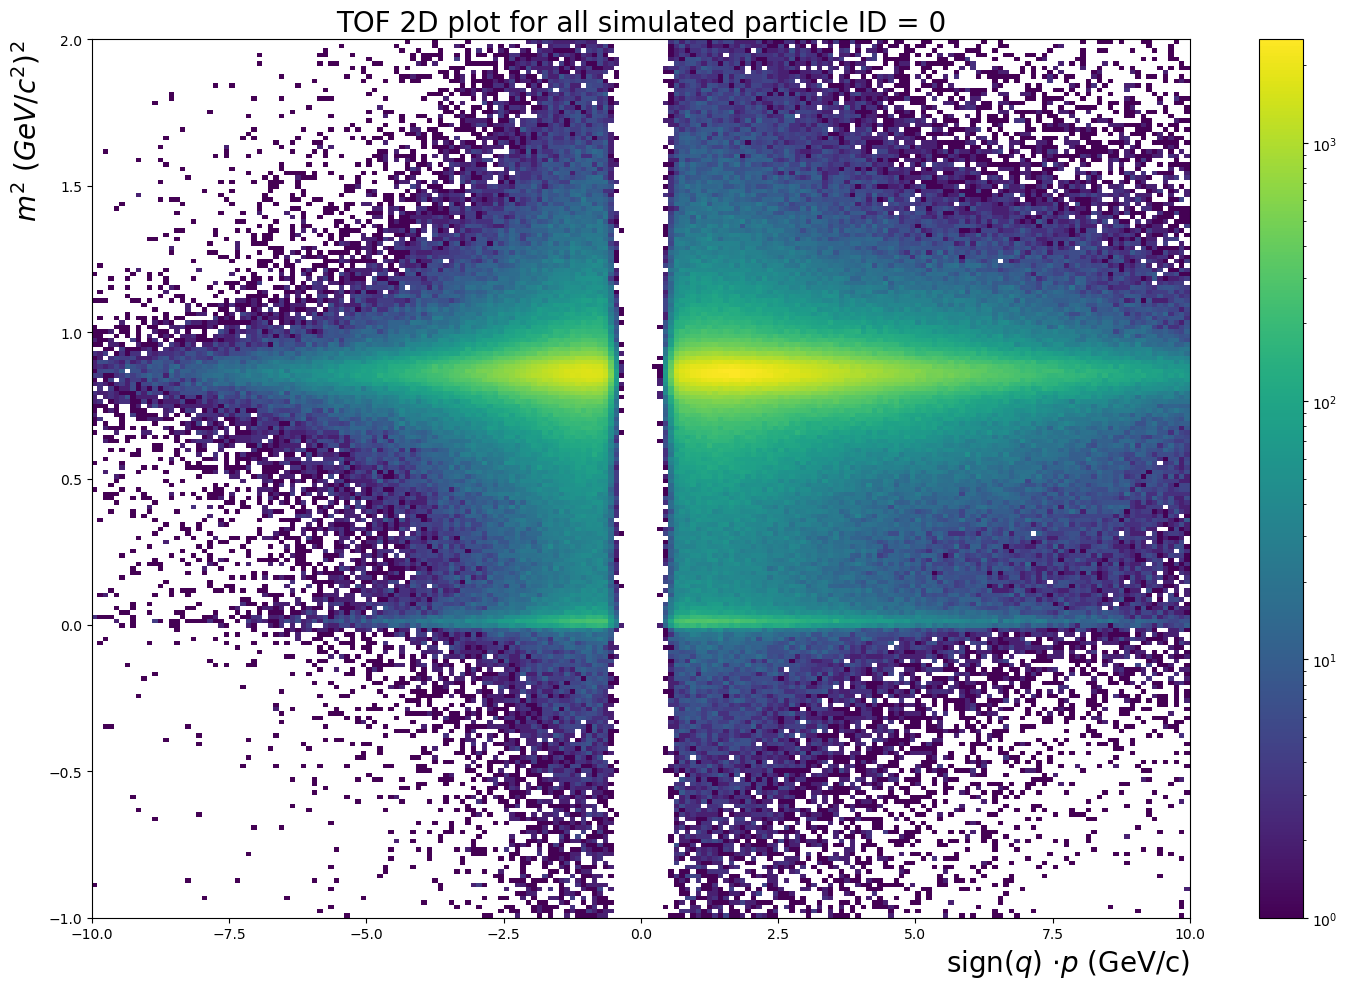

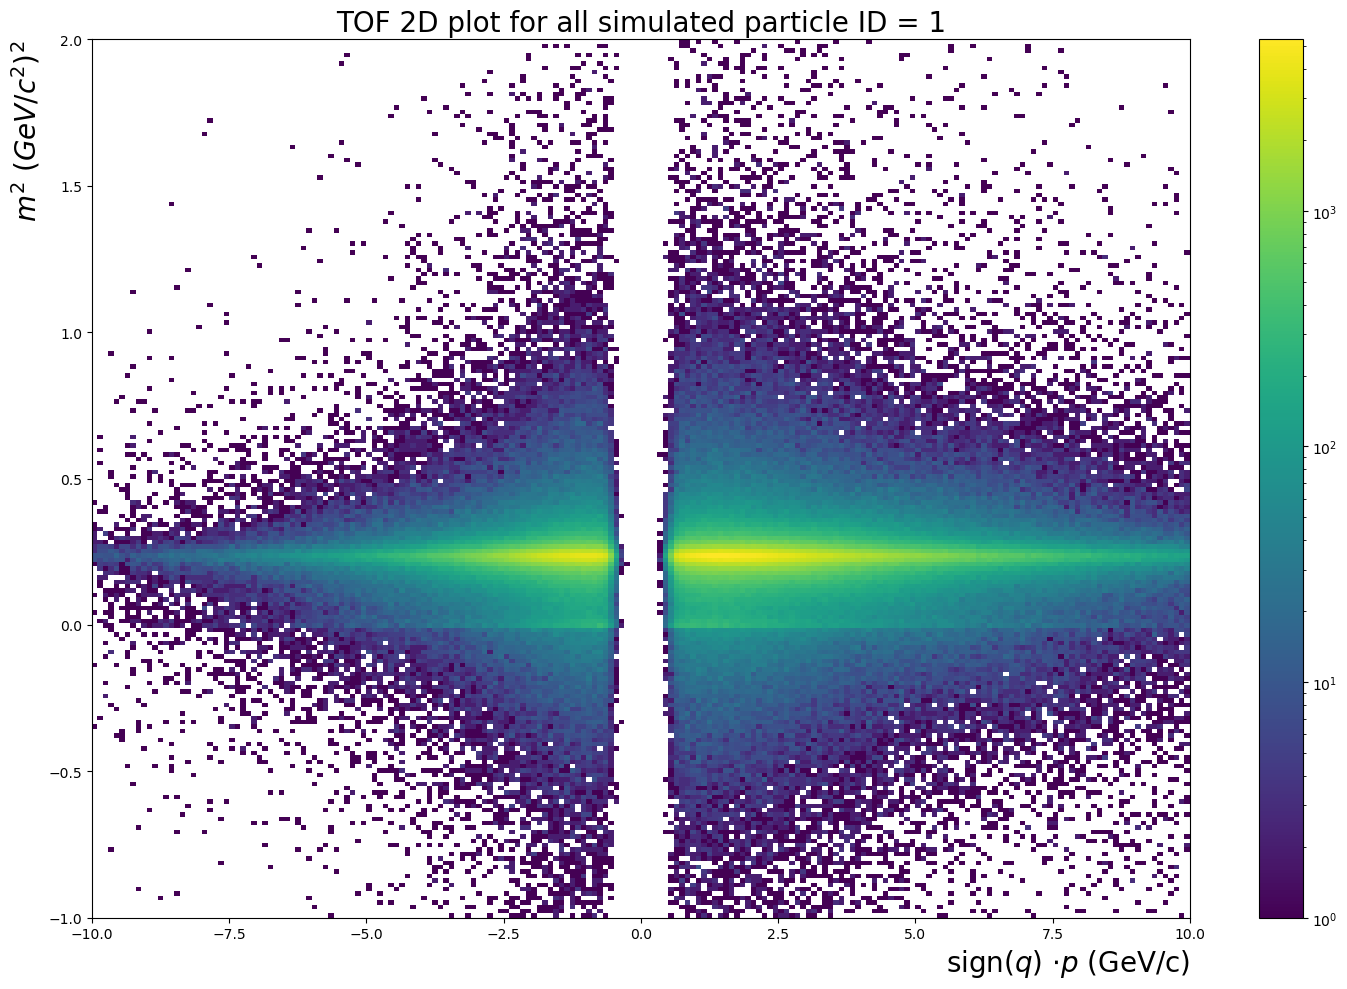

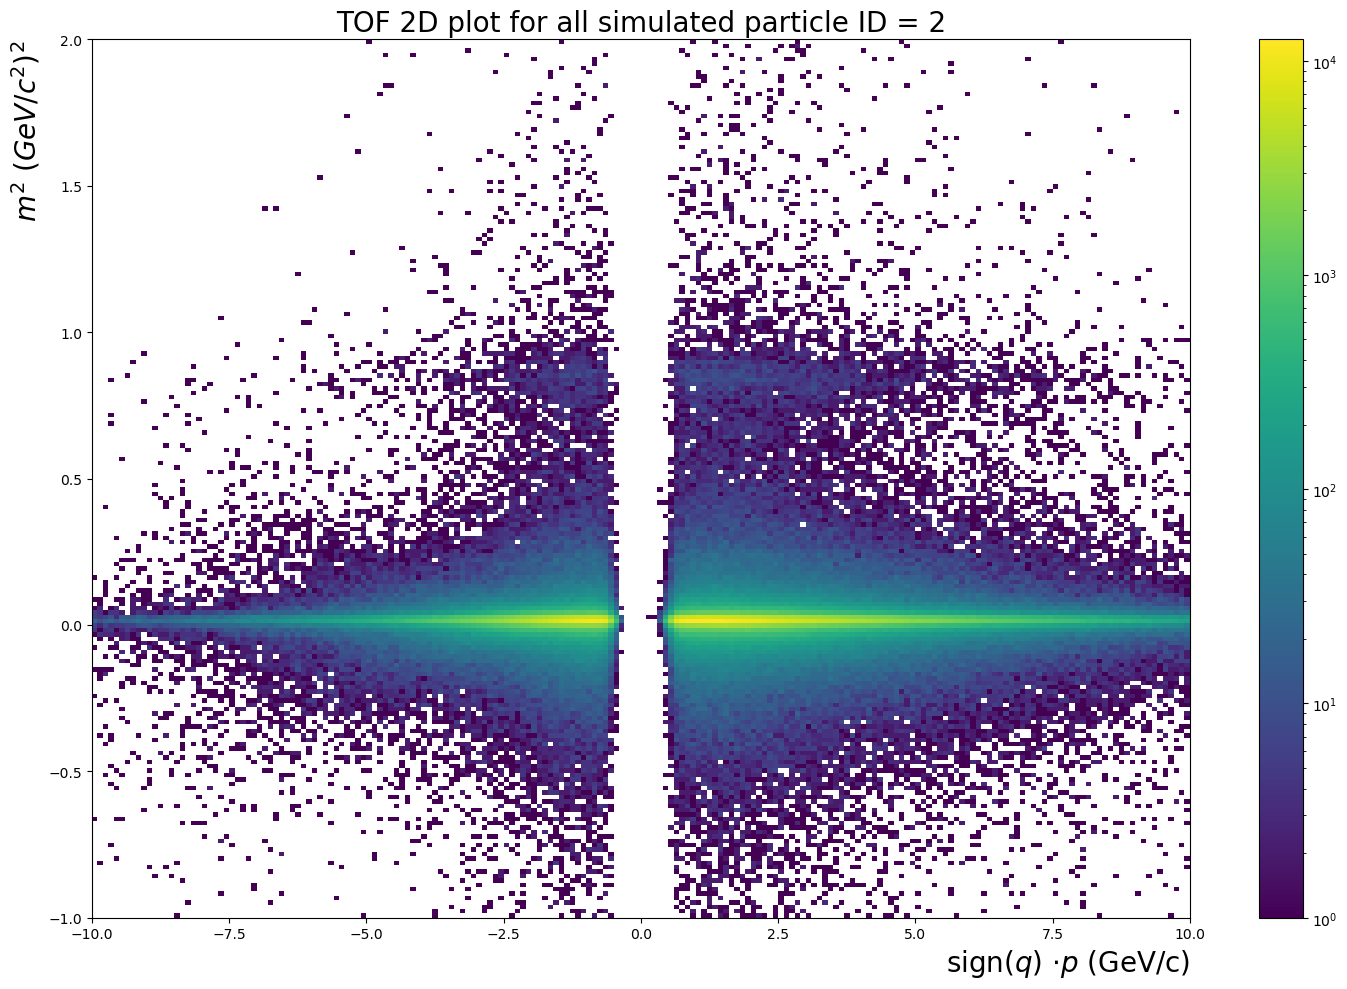

In [55]:
'''before cleaning'''
for i in range(3):
    sim_tof(particles, i)

we get rid of 5.19 % of pid = 0 particle entries
we get rid of 5.01 % of pid = 1 particle entries
we get rid of 2.68 % of pid = 2 particle entries


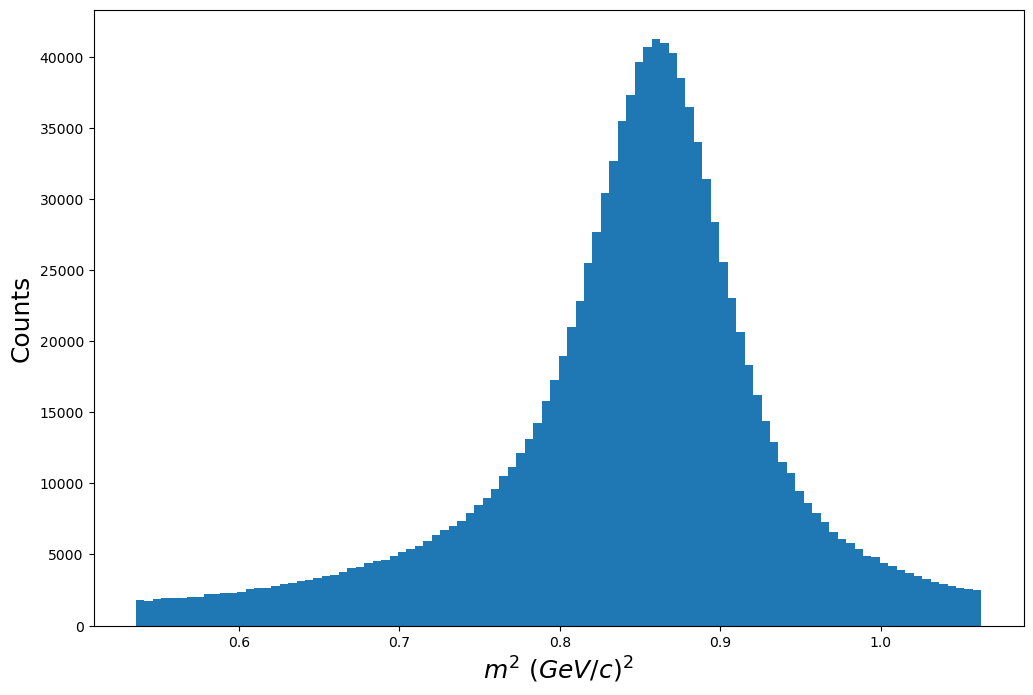

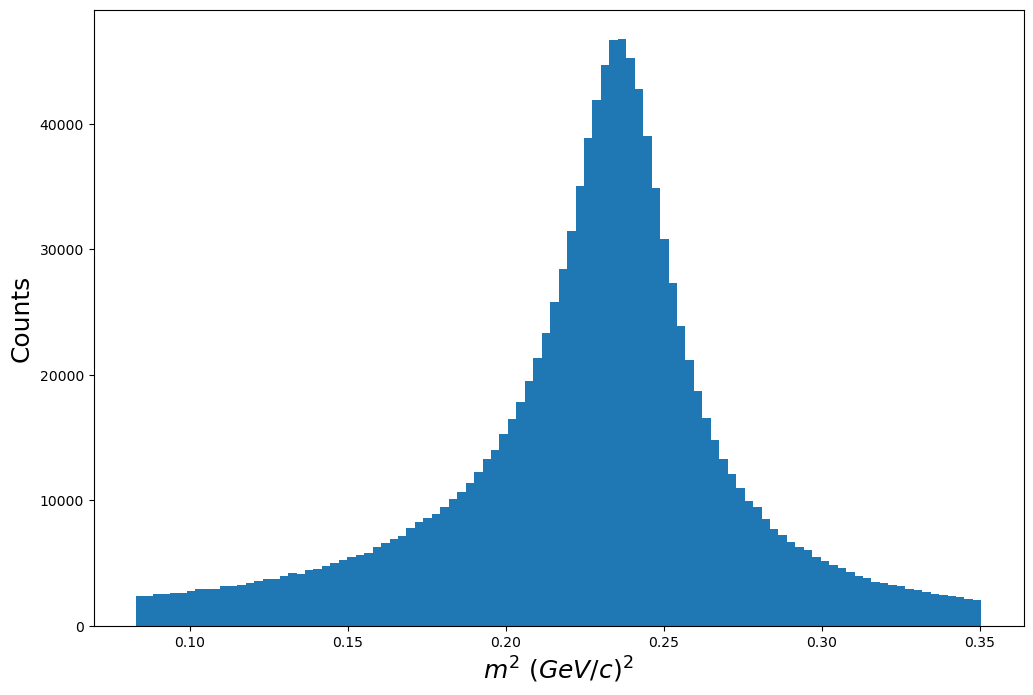

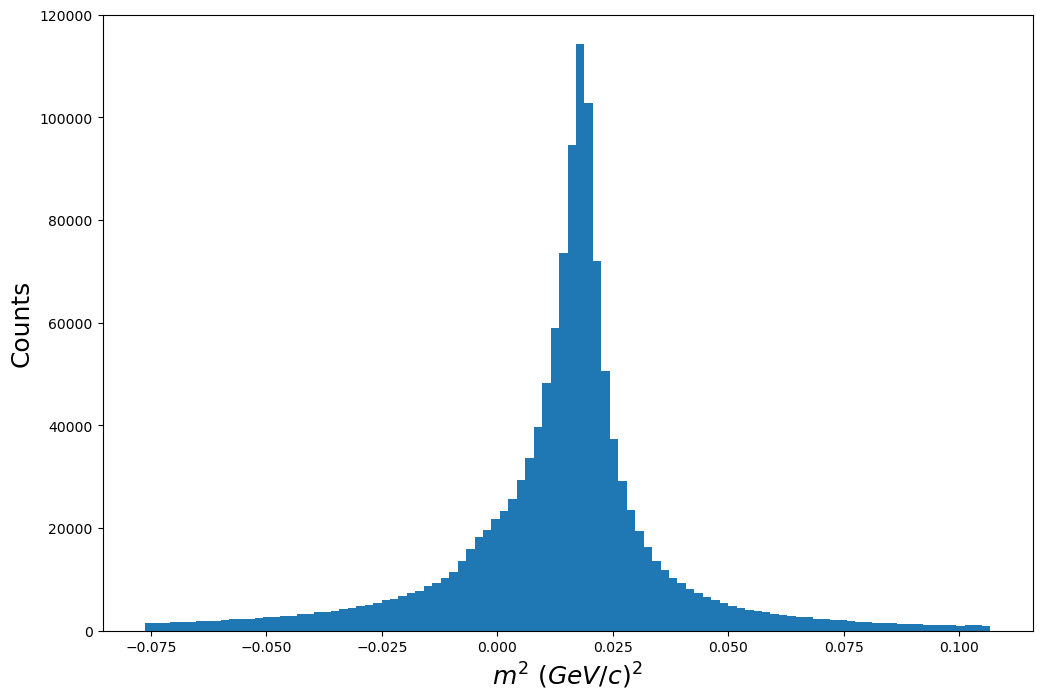

In [56]:
#cleaning and 1sigma region selection
particles = clean_df(particles)
for particle in particles['pid'].unique(): 
    particles = sigma(particles, particle, 1, True)
# we check sigma selection
for pid in particles['pid'].unique():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(particles[particles['pid'] == pid]['mass2'], bins=100)
    ax.set_xlabel('$m^2$ $(GeV/c)^2$',fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    # ax.set_yscale('log')
    
    plt.show()

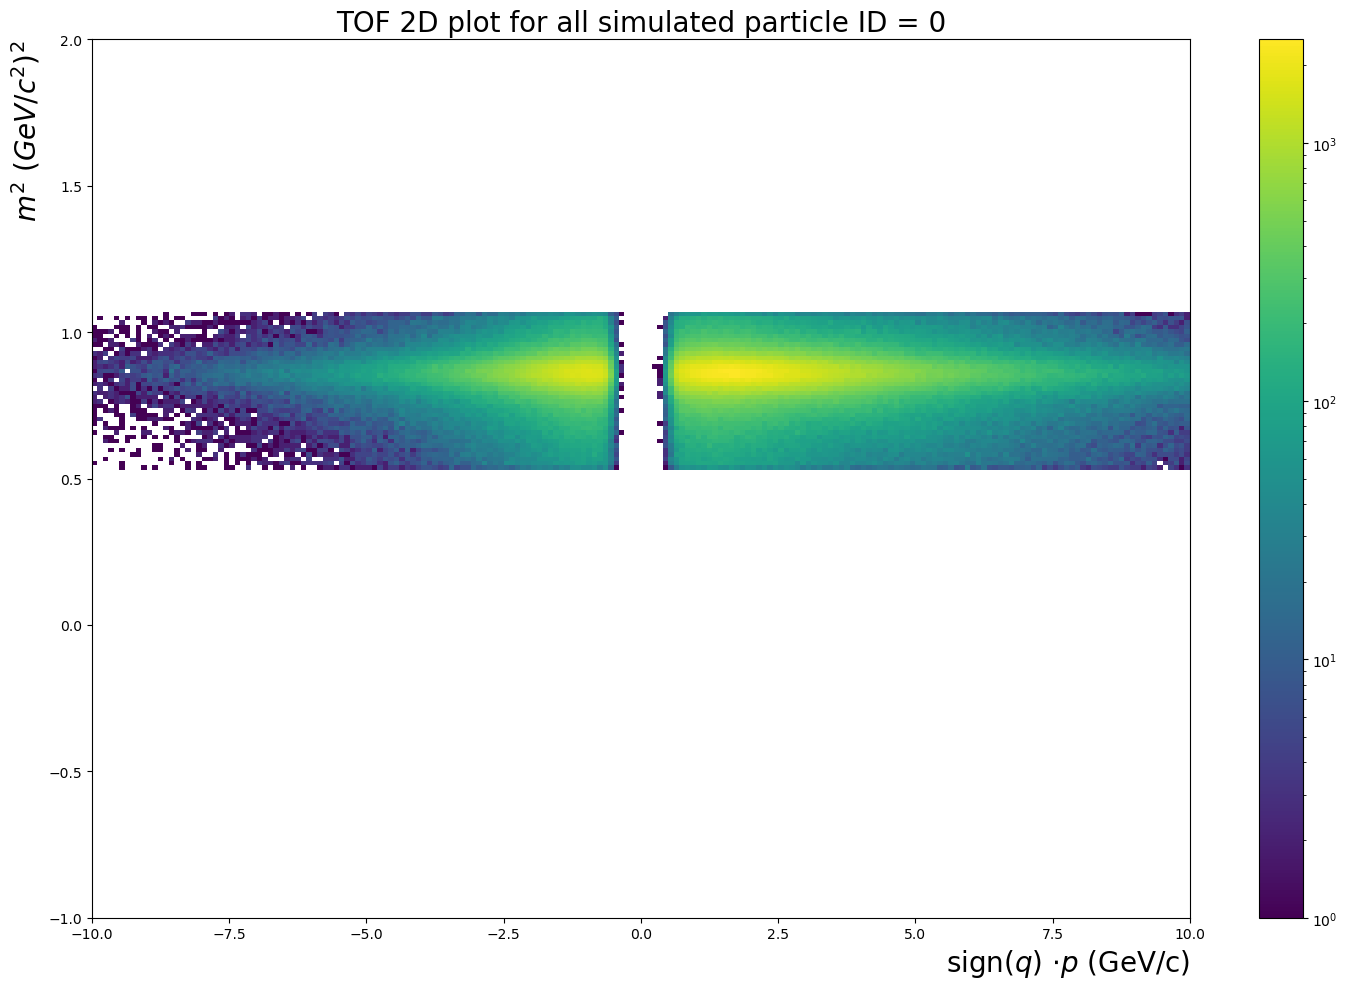

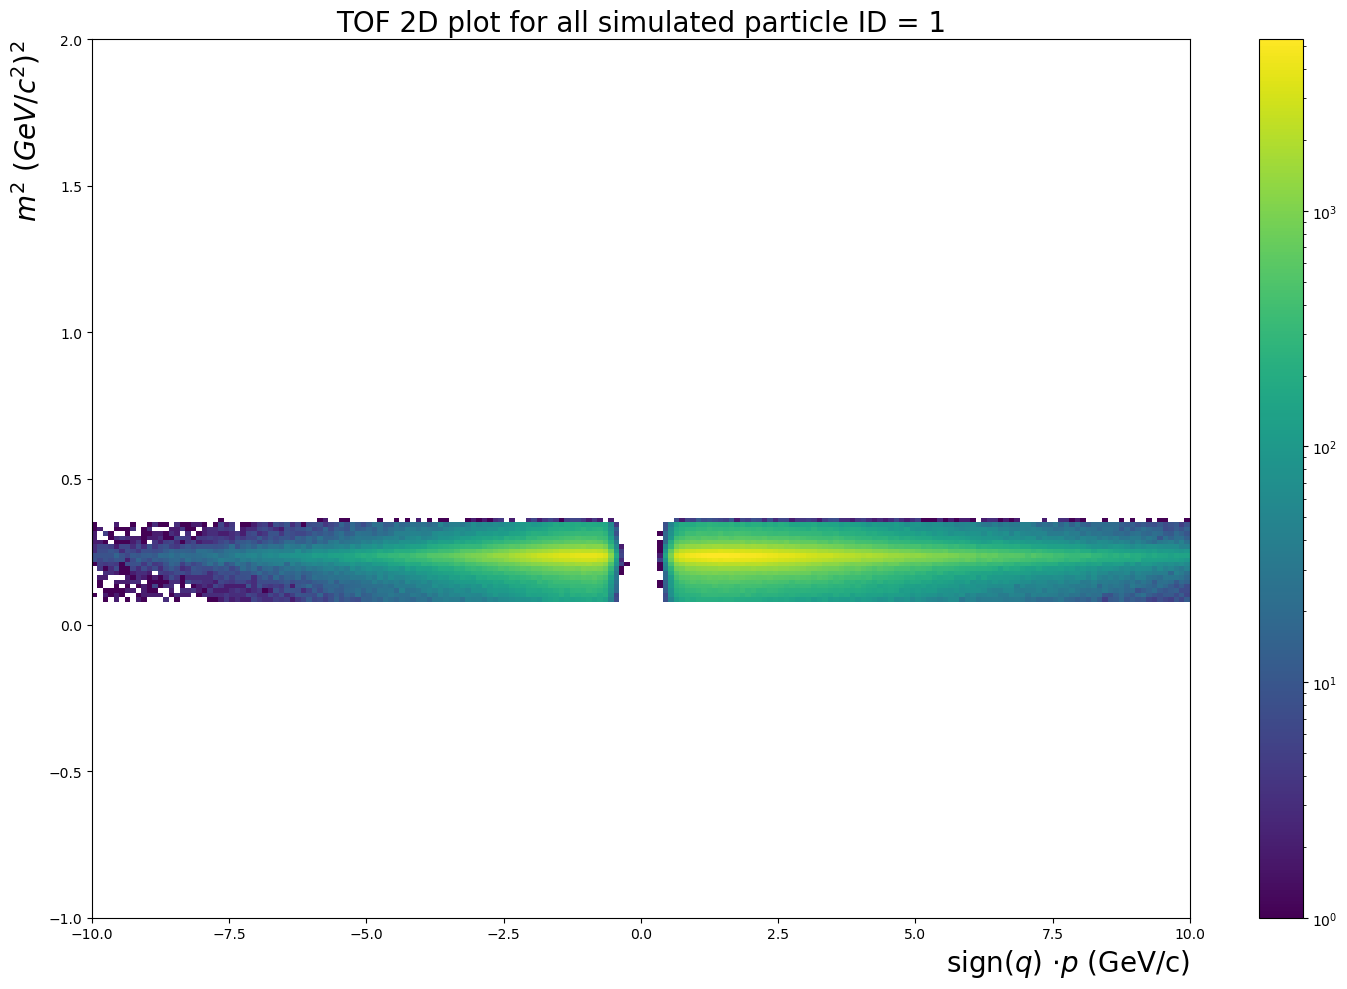

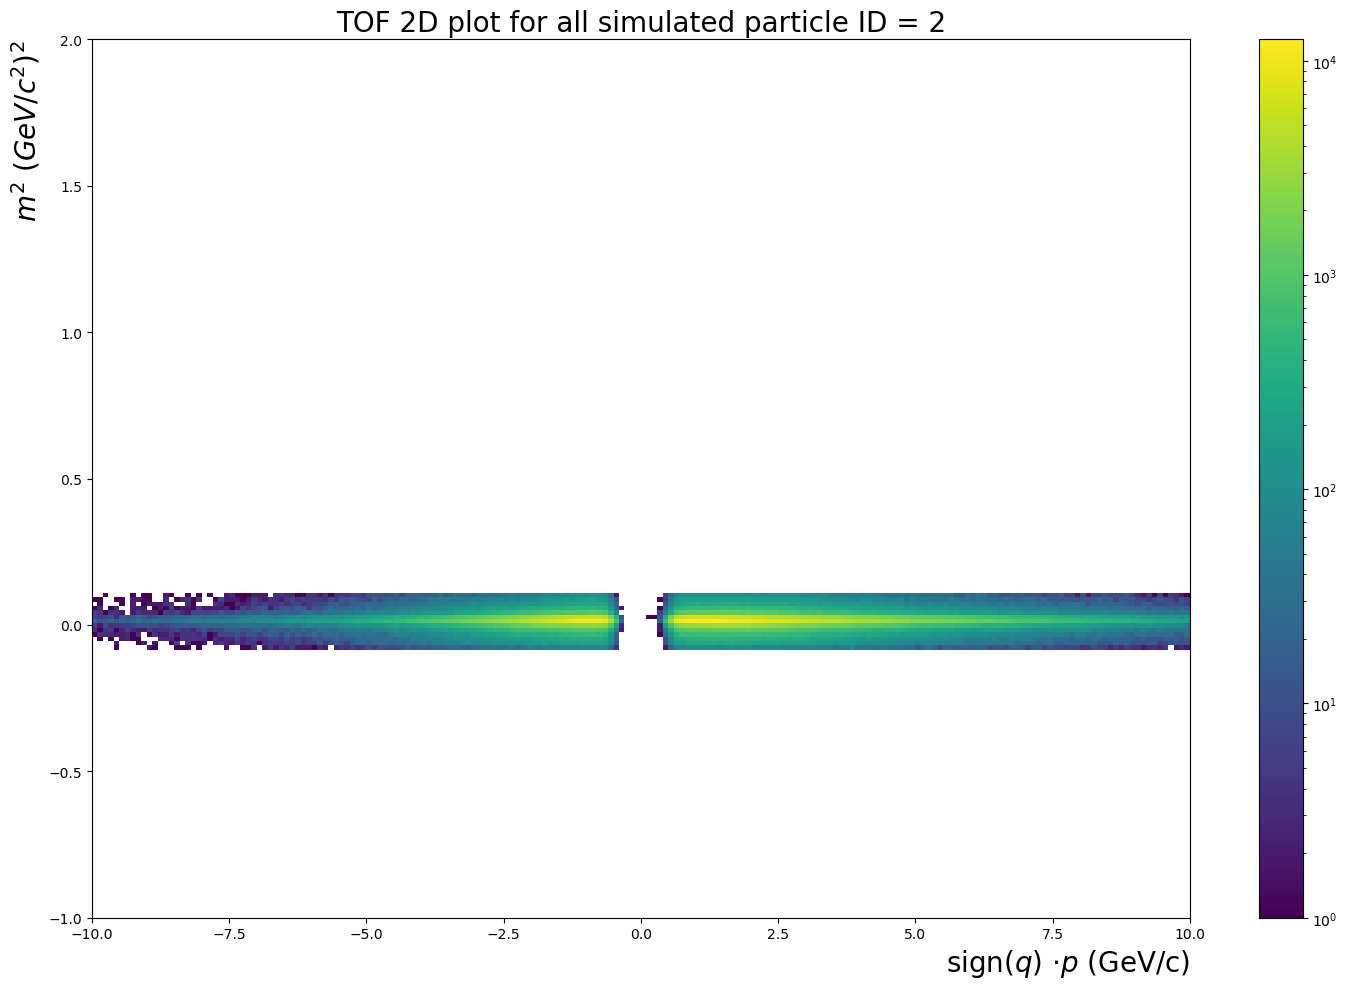

In [57]:
'''after cleaning'''
for i in range(3):
    sim_tof(particles, i)

In [58]:
fig, axs = plt.subplots(figsize=(15, 10))

def subplot(pid, name, color, alpha):
    qp = particles[particles['pid']==pid]['q']*particles[particles['pid']==pid]['p']
    mass2 = particles[particles['pid']==pid]['mass2']
    counts, xedges, yedges, im = axs.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=200), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = alpha)
    plt.colorbar(im, ax=axs)
    # plt.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=100), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = 0.9)

subplot(1, 'kaons', 'Oranges_r', .9)
subplot(2, 'protons', 'Blues_r', .6)



plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title=r'TOF 2D plot for pions (blue) and kaons (orange) for $n_{particles} > 200$'
plt.title(title, fontsize=20)
axs.legend('Classes of particles', fontsize = 20, loc='upper right')
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.show()

NameError: name 'ranges' is not defined